In [259]:
import geopandas as gpd
station_id_map = gpd.read_parquet('station-id-map.parquet')

In [260]:
import pandas as pd
edf = pd.read_parquet('2022-03-entries-start.parquet')

### Forest Park to Harlem Forest Park

In [261]:
edf_previd = (edf.sort_values(['RunNumber','Datetime']).reset_index(drop=True).groupby('RunNumber', group_keys=False)
              .apply(lambda df: df.assign(PrevStationId=df.CurrentStationId.shift(),
                                          NextStationId=df.CurrentStationId.shift(-1),
                                          CurrentStationPrefix=df.CurrentStationId // 1000,
                                          PrevStationPrefix=df.CurrentStationId.shift() // 1000,
                                          NextStationPrefix=df.CurrentStationId.shift(-1) // 1000)
              ))

In [262]:
def get_at_station(station_id, last=False, same_prefix=True, prefix_set=None):
    if prefix_set is None:
        if same_prefix:
            prefix_set = {station_id // 1000}
    if prefix_set is not None:
        if last:
            prefix_clause = ' & NextStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
        else:
            prefix_clause = ' & PrevStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
    else:
        prefix_clause = ''
    
    # FIXME next may be in a different numbering system...
    if last:
        return edf_previd.query('CurrentStationId <= @station_id & NextStationId > @station_id' + prefix_clause).assign(QueryStationId=station_id)
    else:
        return edf_previd.query('CurrentStationId >= @station_id & PrevStationId < @station_id' + prefix_clause).assign(QueryStationId=station_id)
get_at_station(15695)

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags,PrevStationId,NextStationId,CurrentStationPrefix,PrevStationPrefix,NextStationPrefix,QueryStationId
131529,B,2022-03-01 10:20:01,41.87376,-87.80963,101,15695,15705,3.040901,Blu,to,Forest Park,False,ttpm_predslip_blue,,15681.0,11160.0,15,15.0,11.0,15695
132402,B,2022-03-02 10:33:01,41.87376,-87.80963,101,15695,15705,3.040901,Blu,to,Forest Park,False,ttpm_predslip_blue,,15681.0,11101.0,15,15.0,11.0,15695
133629,B,2022-03-04 10:23:42,41.87376,-87.80963,101,15695,15705,3.040901,Blu,to,Forest Park,False,ttpm_predslip_blue,,15681.0,11020.0,15,15.0,11.0,15695
134298,B,2022-03-05 11:05:41,41.87376,-87.80963,101,15695,15705,3.040901,Blu,to,Forest Park,False,ttpm_predslip_blue,,15681.0,11020.0,15,15.0,11.0,15695
134994,B,2022-03-06 14:19:41,41.87376,-87.80963,101,15695,15705,3.040901,Blu,to,Forest Park,False,ttpm_predslip_blue,,15681.0,11020.0,15,15.0,11.0,15695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438631,B,2022-03-07 23:41:41,41.87376,-87.80963,288,15695,15705,3.040901,Blu,to,Forest Park,False,ttpm_predslip_blue,,15680.0,15695.0,15,15.0,15.0,15695
438818,B,2022-03-02 01:32:21,41.87376,-87.80963,289,15695,15705,3.040901,Blu,to,Forest Park,False,ttpm_predslip_blue,,15681.0,15640.0,15,15.0,15.0,15695
438842,B,2022-03-03 01:34:22,41.87376,-87.80963,289,15695,15705,3.040901,Blu,to,Forest Park,False,ttpm_predslip_blue,,15681.0,15600.0,15,15.0,15.0,15695
438897,B,2022-03-03 20:24:42,41.87376,-87.80963,289,15695,15705,3.040901,Blu,to,Forest Park,False,ttpm_predslip_blue,,15681.0,15620.0,15,15.0,15.0,15695


In [263]:
# count what the previous station id was (most are 31580 or 31581, others are likely problems)
get_at_station(15695).PrevStationId.value_counts()

15681.0    432
15680.0     51
15618.0      1
15665.0      1
15660.0      1
Name: PrevStationId, dtype: int64

In [264]:
def get_station_time_diff(sid1, sid2, last=False, same_prefix=True, prefix_set=None):
    """
    sid1 -> sid2 times
    sid1 is the first station id
    sid2 is the second station id 
    last indicates if we are matching when the train leaves the station (True) or arrives (False)
    same_prefix restricts our search to the same two-digit prefix 11, 15, etc.
    prefix_set allows you to search over multiple prefixes
    """
    both_times = (
        pd.concat([get_at_station(sid1, last=last, same_prefix=same_prefix, prefix_set=prefix_set), 
                   get_at_station(sid2, last=last, same_prefix=same_prefix, prefix_set=prefix_set)])
            .groupby('RunNumber', group_keys=False)
            .apply(lambda df: df.sort_values('Datetime').assign(PrevQueryStationId=lambda df: df.QueryStationId.shift(),
                                                                TimeDiff=lambda df: df.Datetime - df.Datetime.shift()))
            .query('PrevQueryStationId == @sid1 & QueryStationId == @sid2')
    )
    return both_times

In [265]:
# Oak Park (11060) to Racine (11220) on the Blue Line
# about 25 minutes
# last=False means includes wait time at Oak Park (no wait time at Racine)

time_diff = get_station_time_diff(15680, 15695)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.describe()

count                          465
mean     0 days 00:01:27.898924731
std      0 days 00:01:32.889351231
min                0 days 00:00:59
25%                0 days 00:01:00
50%                0 days 00:01:19
75%                0 days 00:01:20
max                0 days 00:26:20
Name: TimeDiff, dtype: object

### Harlem-Forest Park to Oak Park-Blue

In [266]:
edf_previd = (edf.sort_values(['RunNumber','Datetime']).reset_index(drop=True).groupby('RunNumber', group_keys=False)
              .apply(lambda df: df.assign(PrevStationId=df.CurrentStationId.shift(),
                                          NextStationId=df.CurrentStationId.shift(-1),
                                          CurrentStationPrefix=df.CurrentStationId // 1000,
                                          PrevStationPrefix=df.CurrentStationId.shift() // 1000,
                                          NextStationPrefix=df.CurrentStationId.shift(-1) // 1000)
              ))

In [267]:
def get_at_station(station_id, last=False, same_prefix=True, prefix_set=None):
    if prefix_set is None:
        if same_prefix:
            prefix_set = {station_id // 1000}
    if prefix_set is not None:
        if last:
            prefix_clause = ' & NextStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
        else:
            prefix_clause = ' & PrevStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
    else:
        prefix_clause = ''
    
    # FIXME next may be in a different numbering system...
    if last:
        return edf_previd.query('CurrentStationId <= @station_id & NextStationId > @station_id' + prefix_clause).assign(QueryStationId=station_id)
    else:
        return edf_previd.query('CurrentStationId >= @station_id & PrevStationId < @station_id' + prefix_clause).assign(QueryStationId=station_id)
get_at_station(11040)

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags,PrevStationId,NextStationId,CurrentStationPrefix,PrevStationPrefix,NextStationPrefix,QueryStationId
131904,B,2022-03-01 14:33:41,41.87349,-87.80696,101,11040,11700,6.183922,Blu,to,O'Hare,False,ttpm_predslip_blue,,11035.0,11040.0,11,11.0,11.0,11040
132828,B,2022-03-02 14:39:42,41.87331,-87.80518,101,11041,11700,6.188481,Blu,to,O'Hare,False,ttpm_predslip_blue,,11035.0,11041.0,11,11.0,11.0,11040
133633,B,2022-03-04 10:42:01,41.87331,-87.80518,101,11041,11700,6.188481,Blu,to,O'Hare,False,ttpm_predslip_blue,,11035.0,11045.0,11,11.0,11.0,11040
134303,B,2022-03-05 11:15:01,41.87349,-87.80696,101,11040,11660,6.183922,Blu,to,Rosemont,False,ttpm_predslip_blue,,11035.0,11040.0,11,11.0,11.0,11040
134507,B,2022-03-05 14:48:21,41.87349,-87.80696,101,11040,11660,6.183922,Blu,to,Rosemont,False,ttpm_predslip_blue,,11035.0,11041.0,11,11.0,11.0,11040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542520,B,2022-03-05 09:32:41,41.87349,-87.80696,1000,11040,11700,6.183922,Blu,to,O'Hare,False,ttpm_predslip_blue,,11035.0,11040.0,11,11.0,11.0,11040
1544181,B,2022-03-07 13:52:21,41.87349,-87.80696,1000,11040,11700,6.183922,Blu,to,O'Hare,False,ttpm_predslip_blue,,11035.0,75220.0,11,11.0,75.0,11040
1544248,B,2022-03-07 16:59:01,41.87349,-87.80696,1000,11040,11700,6.183922,Blu,to,O'Hare,False,ttpm_predslip_blue,,11035.0,11040.0,11,11.0,11.0,11040
1544258,B,2022-03-07 17:08:41,41.87349,-87.80696,1000,11040,11700,6.183922,Blu,to,O'Hare,False,ttpm_predslip_blue,,11020.0,11040.0,11,11.0,11.0,11040


In [268]:
# count what the previous station id was (most are 31580 or 31581, others are likely problems)
get_at_station(11040).PrevStationId.value_counts()

11035.0    509
11020.0     79
11028.0      4
Name: PrevStationId, dtype: int64

In [269]:
def get_station_time_diff(sid1, sid2, last=False, same_prefix=True, prefix_set=None):
    """
    sid1 -> sid2 times
    sid1 is the first station id
    sid2 is the second station id 
    last indicates if we are matching when the train leaves the station (True) or arrives (False)
    same_prefix restricts our search to the same two-digit prefix 11, 15, etc.
    prefix_set allows you to search over multiple prefixes
    """
    both_times = (
        pd.concat([get_at_station(sid1, last=last, same_prefix=same_prefix, prefix_set=prefix_set), 
                   get_at_station(sid2, last=last, same_prefix=same_prefix, prefix_set=prefix_set)])
            .groupby('RunNumber', group_keys=False)
            .apply(lambda df: df.sort_values('Datetime').assign(PrevQueryStationId=lambda df: df.QueryStationId.shift(),
                                                                TimeDiff=lambda df: df.Datetime - df.Datetime.shift()))
            .query('PrevQueryStationId == @sid1 & QueryStationId == @sid2')
    )
    return both_times

In [270]:
# Oak Park (11060) to Racine (11220) on the Blue Line
# about 25 minutes
# last=False means includes wait time at Oak Park (no wait time at Racine)

time_diff = get_station_time_diff(11040,11060)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.describe()

count                          551
mean     0 days 00:02:00.437386569
std      0 days 00:01:06.894619838
min                0 days 00:01:19
25%                0 days 00:01:40
50%                0 days 00:01:41
75%                0 days 00:02:00
max                0 days 00:16:01
Name: TimeDiff, dtype: object

### Oak Park to Austin Blue

In [271]:
edf_previd = (edf.sort_values(['RunNumber','Datetime']).reset_index(drop=True).groupby('RunNumber', group_keys=False)
              .apply(lambda df: df.assign(PrevStationId=df.CurrentStationId.shift(),
                                          NextStationId=df.CurrentStationId.shift(-1),
                                          CurrentStationPrefix=df.CurrentStationId // 1000,
                                          PrevStationPrefix=df.CurrentStationId.shift() // 1000,
                                          NextStationPrefix=df.CurrentStationId.shift(-1) // 1000)
              ))

In [272]:
def get_at_station(station_id, last=False, same_prefix=True, prefix_set=None):
    if prefix_set is None:
        if same_prefix:
            prefix_set = {station_id // 1000}
    if prefix_set is not None:
        if last:
            prefix_clause = ' & NextStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
        else:
            prefix_clause = ' & PrevStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
    else:
        prefix_clause = ''
    
    # FIXME next may be in a different numbering system...
    if last:
        return edf_previd.query('CurrentStationId <= @station_id & NextStationId > @station_id' + prefix_clause).assign(QueryStationId=station_id)
    else:
        return edf_previd.query('CurrentStationId >= @station_id & PrevStationId < @station_id' + prefix_clause).assign(QueryStationId=station_id)
get_at_station(11060)

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags,PrevStationId,NextStationId,CurrentStationPrefix,PrevStationPrefix,NextStationPrefix,QueryStationId
131909,B,2022-03-01 14:35:21,41.87211,-87.7916,101,11060,11700,6.19543,Blu,to,O'Hare,False,ttpm_predslip_blue,,11055.0,11060.0,11,11.0,11.0,11060
132833,B,2022-03-02 14:41:21,41.87211,-87.7916,101,11060,11700,6.19543,Blu,to,O'Hare,False,ttpm_predslip_blue,,11058.0,11060.0,11,11.0,11.0,11060
133267,B,2022-03-03 14:27:21,41.87211,-87.7916,101,11060,11700,6.19543,Blu,to,O'Hare,False,ttpm_predslip_blue,,11058.0,11060.0,11,11.0,11.0,11060
133638,B,2022-03-04 10:43:41,41.87211,-87.7916,101,11060,11700,6.19543,Blu,to,O'Hare,False,ttpm_predslip_blue,,11058.0,11060.0,11,11.0,11.0,11060
134309,B,2022-03-05 11:17:01,41.87211,-87.7916,101,11060,11660,6.19543,Blu,to,Rosemont,False,ttpm_predslip_blue,,11058.0,11060.0,11,11.0,11.0,11060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542155,B,2022-03-04 19:24:21,41.87211,-87.7916,1000,11060,11700,6.19543,Blu,to,O'Hare,False,ttpm_predslip_blue,,11058.0,11060.0,11,11.0,11.0,11060
1542196,B,2022-03-05 01:41:21,41.87211,-87.7916,1000,11060,11700,6.19543,Blu,to,O'Hare,False,ttpm_predslip_blue,,11058.0,15043.0,11,11.0,15.0,11060
1544254,B,2022-03-07 17:01:01,41.87211,-87.7916,1000,11060,11700,6.19543,Blu,to,O'Hare,False,ttpm_predslip_blue,,11058.0,11020.0,11,11.0,11.0,11060
1544264,B,2022-03-07 17:10:42,41.87211,-87.7916,1000,11060,11700,6.19543,Blu,to,O'Hare,False,ttpm_predslip_blue,,11058.0,11060.0,11,11.0,11.0,11060


In [273]:
# count what the previous station id was (most are 31580 or 31581, others are likely problems)
get_at_station(11060).PrevStationId.value_counts()

11058.0    491
11055.0     98
11050.0     15
11052.0      7
11020.0      4
11035.0      3
11041.0      2
11028.0      2
11040.0      2
Name: PrevStationId, dtype: int64

In [274]:
def get_station_time_diff(sid1, sid2, last=False, same_prefix=True, prefix_set=None):
    """
    sid1 -> sid2 times
    sid1 is the first station id
    sid2 is the second station id 
    last indicates if we are matching when the train leaves the station (True) or arrives (False)
    same_prefix restricts our search to the same two-digit prefix 11, 15, etc.
    prefix_set allows you to search over multiple prefixes
    """
    both_times = (
        pd.concat([get_at_station(sid1, last=last, same_prefix=same_prefix, prefix_set=prefix_set), 
                   get_at_station(sid2, last=last, same_prefix=same_prefix, prefix_set=prefix_set)])
            .groupby('RunNumber', group_keys=False)
            .apply(lambda df: df.sort_values('Datetime').assign(PrevQueryStationId=lambda df: df.QueryStationId.shift(),
                                                                TimeDiff=lambda df: df.Datetime - df.Datetime.shift()))
            .query('PrevQueryStationId == @sid1 & QueryStationId == @sid2')
    )
    return both_times

In [275]:
# Oak Park (11060) to Racine (11220) on the Blue Line
# about 25 minutes
# last=False means includes wait time at Oak Park (no wait time at Racine)

time_diff = get_station_time_diff(11060,11080)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.describe()

count                          579
mean     0 days 00:03:45.412780656
std      0 days 00:00:55.332532735
min                0 days 00:01:59
25%                0 days 00:03:20
50%                0 days 00:03:40
75%                0 days 00:03:41
max                0 days 00:13:20
Name: TimeDiff, dtype: object

### Austin Blue to Cicero Forest Park

In [276]:
edf_previd = (edf.sort_values(['RunNumber','Datetime']).reset_index(drop=True).groupby('RunNumber', group_keys=False)
              .apply(lambda df: df.assign(PrevStationId=df.CurrentStationId.shift(),
                                          NextStationId=df.CurrentStationId.shift(-1),
                                          CurrentStationPrefix=df.CurrentStationId // 1000,
                                          PrevStationPrefix=df.CurrentStationId.shift() // 1000,
                                          NextStationPrefix=df.CurrentStationId.shift(-1) // 1000)
              ))

In [277]:
def get_at_station(station_id, last=False, same_prefix=True, prefix_set=None):
    if prefix_set is None:
        if same_prefix:
            prefix_set = {station_id // 1000}
    if prefix_set is not None:
        if last:
            prefix_clause = ' & NextStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
        else:
            prefix_clause = ' & PrevStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
    else:
        prefix_clause = ''
    
    # FIXME next may be in a different numbering system...
    if last:
        return edf_previd.query('CurrentStationId <= @station_id & NextStationId > @station_id' + prefix_clause).assign(QueryStationId=station_id)
    else:
        return edf_previd.query('CurrentStationId >= @station_id & PrevStationId < @station_id' + prefix_clause).assign(QueryStationId=station_id)
get_at_station(11080)

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags,PrevStationId,NextStationId,CurrentStationPrefix,PrevStationPrefix,NextStationPrefix,QueryStationId
131920,B,2022-03-01 14:39:01,41.87089,-87.77681,101,11080,11700,6.221108,Blu,to,O'Hare,False,ttpm_predslip_blue,,11078.0,11080.0,11,11.0,11.0,11080
132844,B,2022-03-02 14:45:01,41.87089,-87.77681,101,11080,11700,6.221108,Blu,to,O'Hare,False,ttpm_predslip_blue,,11078.0,11081.0,11,11.0,11.0,11080
133278,B,2022-03-03 14:31:01,41.87089,-87.77681,101,11080,11700,6.221108,Blu,to,O'Hare,False,ttpm_predslip_blue,,11078.0,11080.0,11,11.0,11.0,11080
133656,B,2022-03-04 10:49:42,41.87089,-87.77681,101,11080,11700,6.221108,Blu,to,O'Hare,False,ttpm_predslip_blue,,11078.0,11080.0,11,11.0,11.0,11080
134319,B,2022-03-05 11:20:21,41.87089,-87.77681,101,11080,11660,6.221108,Blu,to,Rosemont,False,ttpm_predslip_blue,,11078.0,11080.0,11,11.0,11.0,11080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437223,B,2022-03-07 07:24:01,41.87498,-87.70218,232,11150,11660,0.145020,Blu,to,Rosemont,False,ttpm_predslip_blue,,11020.0,11152.0,11,11.0,11.0,11080
437619,B,2022-03-07 10:21:41,41.87079,-87.77521,232,11081,11700,6.221575,Blu,to,O'Hare,False,ttpm_predslip_blue,,11078.0,11084.0,11,11.0,11.0,11080
1539614,B,2022-03-01 09:12:41,41.87089,-87.77681,1000,11080,11700,6.221108,Blu,to,O'Hare,False,ttpm_predslip_blue,,11078.0,11080.0,11,11.0,11.0,11080
1541680,B,2022-03-04 04:27:01,41.87089,-87.77681,1000,11080,11700,6.221108,Blu,to,O'Hare,False,ttpm_predslip_blue,,11078.0,11081.0,11,11.0,11.0,11080


In [278]:
# count what the previous station id was (most are 31580 or 31581, others are likely problems)
get_at_station(11080).PrevStationId.value_counts()

11078.0    501
11072.0     99
11070.0     14
11020.0      4
11068.0      3
11050.0      3
11058.0      2
11065.0      2
11035.0      2
11061.0      2
11060.0      2
11028.0      1
11040.0      1
Name: PrevStationId, dtype: int64

In [279]:
def get_station_time_diff(sid1, sid2, last=False, same_prefix=True, prefix_set=None):
    """
    sid1 -> sid2 times
    sid1 is the first station id
    sid2 is the second station id 
    last indicates if we are matching when the train leaves the station (True) or arrives (False)
    same_prefix restricts our search to the same two-digit prefix 11, 15, etc.
    prefix_set allows you to search over multiple prefixes
    """
    both_times = (
        pd.concat([get_at_station(sid1, last=last, same_prefix=same_prefix, prefix_set=prefix_set), 
                   get_at_station(sid2, last=last, same_prefix=same_prefix, prefix_set=prefix_set)])
            .groupby('RunNumber', group_keys=False)
            .apply(lambda df: df.sort_values('Datetime').assign(PrevQueryStationId=lambda df: df.QueryStationId.shift(),
                                                                TimeDiff=lambda df: df.Datetime - df.Datetime.shift()))
            .query('PrevQueryStationId == @sid1 & QueryStationId == @sid2')
    )
    return both_times

In [280]:
# Oak Park (11060) to Racine (11220) on the Blue Line
# about 25 minutes
# last=False means includes wait time at Oak Park (no wait time at Racine)

time_diff = get_station_time_diff(11080,11100)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.describe()

count                          594
mean     0 days 00:05:22.831649831
std      0 days 00:01:40.310858865
min                0 days 00:01:00
25%                0 days 00:05:00
50%                0 days 00:05:01
75%                0 days 00:05:20
max                0 days 00:27:19
Name: TimeDiff, dtype: object

### Cicero Forest Park to Pulaski Forest Park

In [281]:
edf_previd = (edf.sort_values(['RunNumber','Datetime']).reset_index(drop=True).groupby('RunNumber', group_keys=False)
              .apply(lambda df: df.assign(PrevStationId=df.CurrentStationId.shift(),
                                          NextStationId=df.CurrentStationId.shift(-1),
                                          CurrentStationPrefix=df.CurrentStationId // 1000,
                                          PrevStationPrefix=df.CurrentStationId.shift() // 1000,
                                          NextStationPrefix=df.CurrentStationId.shift(-1) // 1000)
              ))

In [282]:
def get_at_station(station_id, last=False, same_prefix=True, prefix_set=None):
    if prefix_set is None:
        if same_prefix:
            prefix_set = {station_id // 1000}
    if prefix_set is not None:
        if last:
            prefix_clause = ' & NextStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
        else:
            prefix_clause = ' & PrevStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
    else:
        prefix_clause = ''
    
    # FIXME next may be in a different numbering system...
    if last:
        return edf_previd.query('CurrentStationId <= @station_id & NextStationId > @station_id' + prefix_clause).assign(QueryStationId=station_id)
    else:
        return edf_previd.query('CurrentStationId >= @station_id & PrevStationId < @station_id' + prefix_clause).assign(QueryStationId=station_id)
get_at_station(11100)

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags,PrevStationId,NextStationId,CurrentStationPrefix,PrevStationPrefix,NextStationPrefix,QueryStationId
131935,B,2022-03-01 14:44:01,41.87161,-87.74515,101,11100,11700,6.270655,Blu,to,O'Hare,False,ttpm_predslip_blue,,11098.0,11101.0,11,11.0,11.0,11100
133294,B,2022-03-03 14:36:22,41.87161,-87.74515,101,11100,11700,6.270655,Blu,to,O'Hare,False,ttpm_predslip_blue,,11098.0,11101.0,11,11.0,11.0,11100
133671,B,2022-03-04 10:54:42,41.87161,-87.74515,101,11100,11700,6.270655,Blu,to,O'Hare,False,ttpm_predslip_blue,,11094.0,11100.0,11,11.0,11.0,11100
134336,B,2022-03-05 11:26:01,41.87161,-87.74515,101,11100,11660,6.270655,Blu,to,Rosemont,False,ttpm_predslip_blue,,11094.0,11100.0,11,11.0,11.0,11100
134538,B,2022-03-05 14:58:41,41.87161,-87.74515,101,11100,11660,6.270655,Blu,to,Rosemont,False,ttpm_predslip_blue,,11098.0,11100.0,11,11.0,11.0,11100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436850,B,2022-03-04 03:40:01,41.87161,-87.74515,232,11100,11700,6.270655,Blu,to,O'Hare,False,ttpm_predslip_blue,,11098.0,11101.0,11,11.0,11.0,11100
436932,B,2022-03-07 04:15:01,41.87161,-87.74515,232,11100,11660,6.270655,Blu,to,Rosemont,False,ttpm_predslip_blue,,11098.0,11100.0,11,11.0,11.0,11100
437223,B,2022-03-07 07:24:01,41.87498,-87.70218,232,11150,11660,0.145020,Blu,to,Rosemont,False,ttpm_predslip_blue,,11020.0,11152.0,11,11.0,11.0,11100
437633,B,2022-03-07 10:26:21,41.87161,-87.74515,232,11100,11700,6.270655,Blu,to,O'Hare,False,ttpm_predslip_blue,,11098.0,11100.0,11,11.0,11.0,11100


In [283]:
# count what the previous station id was (most are 31580 or 31581, others are likely problems)
get_at_station(11100).PrevStationId.value_counts()

11098.0    460
11094.0    138
11093.0     19
11020.0      3
11078.0      2
11060.0      2
11085.0      2
11035.0      2
11065.0      2
11080.0      2
11092.0      1
11050.0      1
11061.0      1
11058.0      1
11028.0      1
11068.0      1
11090.0      1
11081.0      1
11040.0      1
Name: PrevStationId, dtype: int64

In [284]:
def get_station_time_diff(sid1, sid2, last=False, same_prefix=True, prefix_set=None):
    """
    sid1 -> sid2 times
    sid1 is the first station id
    sid2 is the second station id 
    last indicates if we are matching when the train leaves the station (True) or arrives (False)
    same_prefix restricts our search to the same two-digit prefix 11, 15, etc.
    prefix_set allows you to search over multiple prefixes
    """
    both_times = (
        pd.concat([get_at_station(sid1, last=last, same_prefix=same_prefix, prefix_set=prefix_set), 
                   get_at_station(sid2, last=last, same_prefix=same_prefix, prefix_set=prefix_set)])
            .groupby('RunNumber', group_keys=False)
            .apply(lambda df: df.sort_values('Datetime').assign(PrevQueryStationId=lambda df: df.QueryStationId.shift(),
                                                                TimeDiff=lambda df: df.Datetime - df.Datetime.shift()))
            .query('PrevQueryStationId == @sid1 & QueryStationId == @sid2')
    )
    return both_times

In [285]:
# Oak Park (11060) to Racine (11220) on the Blue Line
# about 25 minutes
# last=False means includes wait time at Oak Park (no wait time at Racine)

time_diff = get_station_time_diff(11100,11220)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.describe()

count                          606
mean     0 days 00:16:06.943894389
std      0 days 00:02:18.594098430
min                0 days 00:02:40
25%                0 days 00:15:21
50%                0 days 00:16:00
75%                0 days 00:16:40
max                0 days 00:29:39
Name: TimeDiff, dtype: object

### Pulaski Forest Park to Kedzie-Homan

In [286]:
edf_previd = (edf.sort_values(['RunNumber','Datetime']).reset_index(drop=True).groupby('RunNumber', group_keys=False)
              .apply(lambda df: df.assign(PrevStationId=df.CurrentStationId.shift(),
                                          NextStationId=df.CurrentStationId.shift(-1),
                                          CurrentStationPrefix=df.CurrentStationId // 1000,
                                          PrevStationPrefix=df.CurrentStationId.shift() // 1000,
                                          NextStationPrefix=df.CurrentStationId.shift(-1) // 1000)
              ))

In [287]:
def get_at_station(station_id, last=False, same_prefix=True, prefix_set=None):
    if prefix_set is None:
        if same_prefix:
            prefix_set = {station_id // 1000}
    if prefix_set is not None:
        if last:
            prefix_clause = ' & NextStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
        else:
            prefix_clause = ' & PrevStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
    else:
        prefix_clause = ''
    
    # FIXME next may be in a different numbering system...
    if last:
        return edf_previd.query('CurrentStationId <= @station_id & NextStationId > @station_id' + prefix_clause).assign(QueryStationId=station_id)
    else:
        return edf_previd.query('CurrentStationId >= @station_id & PrevStationId < @station_id' + prefix_clause).assign(QueryStationId=station_id)
get_at_station(11220)

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags,PrevStationId,NextStationId,CurrentStationPrefix,PrevStationPrefix,NextStationPrefix,QueryStationId
131544,B,2022-03-01 11:10:01,41.87589,-87.65946,101,11220,11700,0.019792,Blu,to,O'Hare,False,ttpm_predslip_blue,,11198.0,11220.0,11,11.0,11.0,11220
131987,B,2022-03-01 15:01:21,41.87589,-87.65946,101,11220,11700,0.019792,Blu,to,O'Hare,False,ttpm_predslip_blue,,11198.0,11220.0,11,11.0,11.0,11220
132447,B,2022-03-02 11:17:41,41.87589,-87.65946,101,11220,11700,0.019792,Blu,to,O'Hare,False,ttpm_predslip_blue,,11198.0,11220.0,11,11.0,11.0,11220
133350,B,2022-03-03 14:55:01,41.87588,-87.65755,101,11221,11700,6.232501,Blu,to,O'Hare,False,ttpm_predslip_blue,,11198.0,11221.0,11,11.0,11.0,11220
133723,B,2022-03-04 11:12:01,41.87589,-87.65946,101,11220,11700,0.019792,Blu,to,O'Hare,False,ttpm_predslip_blue,,11219.0,11221.0,11,11.0,11.0,11220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563340,B,2022-03-02 23:16:02,41.87589,-87.65946,320,11220,11700,0.019792,Blu,to,O'Hare,False,ttpm_predslip_blue,,11219.0,11230.0,11,11.0,11.0,11220
564506,B,2022-03-03 23:17:41,41.87589,-87.65946,320,11220,11700,0.019792,Blu,to,O'Hare,False,ttpm_predslip_blue,,11206.0,11220.0,11,11.0,11.0,11220
565485,B,2022-03-04 23:19:01,41.87589,-87.65946,320,11220,11700,0.019792,Blu,to,O'Hare,False,ttpm_predslip_blue,,11206.0,11220.0,11,11.0,11.0,11220
566497,B,2022-03-07 23:17:01,41.87589,-87.65946,320,11220,11700,0.019792,Blu,to,O'Hare,False,ttpm_predslip_blue,,11206.0,11220.0,11,11.0,11.0,11220


In [288]:
# count what the previous station id was (most are 31580 or 31581, others are likely problems)
get_at_station(11220).PrevStationId.value_counts()

11198.0    427
11219.0    180
11192.0     19
11206.0      7
11190.0      4
11178.0      3
11175.0      3
11128.0      2
11188.0      2
11132.0      2
11138.0      2
11085.0      2
11180.0      2
11130.0      1
11093.0      1
11170.0      1
11105.0      1
11078.0      1
11081.0      1
11028.0      1
11158.0      1
11060.0      1
11156.0      1
11080.0      1
11110.0      1
11161.0      1
11035.0      1
Name: PrevStationId, dtype: int64

In [289]:
def get_station_time_diff(sid1, sid2, last=False, same_prefix=True, prefix_set=None):
    """
    sid1 -> sid2 times
    sid1 is the first station id
    sid2 is the second station id 
    last indicates if we are matching when the train leaves the station (True) or arrives (False)
    same_prefix restricts our search to the same two-digit prefix 11, 15, etc.
    prefix_set allows you to search over multiple prefixes
    """
    both_times = (
        pd.concat([get_at_station(sid1, last=last, same_prefix=same_prefix, prefix_set=prefix_set), 
                   get_at_station(sid2, last=last, same_prefix=same_prefix, prefix_set=prefix_set)])
            .groupby('RunNumber', group_keys=False)
            .apply(lambda df: df.sort_values('Datetime').assign(PrevQueryStationId=lambda df: df.QueryStationId.shift(),
                                                                TimeDiff=lambda df: df.Datetime - df.Datetime.shift()))
            .query('PrevQueryStationId == @sid1 & QueryStationId == @sid2')
    )
    return both_times

In [290]:
# Oak Park (11060) to Racine (11220) on the Blue Line
# about 25 minutes
# last=False means includes wait time at Oak Park (no wait time at Racine)

time_diff = get_station_time_diff(15578, 15600)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.describe()

count                          619
mean     0 days 00:05:29.691437802
std      0 days 00:02:01.195955590
min                0 days 00:01:20
25%                0 days 00:05:00
50%                0 days 00:05:19
75%                0 days 00:05:21
max                0 days 00:29:40
Name: TimeDiff, dtype: object

### Kedzie Homan to Western Forest Park

In [291]:
edf_previd = (edf.sort_values(['RunNumber','Datetime']).reset_index(drop=True).groupby('RunNumber', group_keys=False)
              .apply(lambda df: df.assign(PrevStationId=df.CurrentStationId.shift(),
                                          NextStationId=df.CurrentStationId.shift(-1),
                                          CurrentStationPrefix=df.CurrentStationId // 1000,
                                          PrevStationPrefix=df.CurrentStationId.shift() // 1000,
                                          NextStationPrefix=df.CurrentStationId.shift(-1) // 1000)
              ))

In [292]:
def get_at_station(station_id, last=False, same_prefix=True, prefix_set=None):
    if prefix_set is None:
        if same_prefix:
            prefix_set = {station_id // 1000}
    if prefix_set is not None:
        if last:
            prefix_clause = ' & NextStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
        else:
            prefix_clause = ' & PrevStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
    else:
        prefix_clause = ''
    
    # FIXME next may be in a different numbering system...
    if last:
        return edf_previd.query('CurrentStationId <= @station_id & NextStationId > @station_id' + prefix_clause).assign(QueryStationId=station_id)
    else:
        return edf_previd.query('CurrentStationId >= @station_id & PrevStationId < @station_id' + prefix_clause).assign(QueryStationId=station_id)
get_at_station(11140)

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags,PrevStationId,NextStationId,CurrentStationPrefix,PrevStationPrefix,NextStationPrefix,QueryStationId
131964,B,2022-03-01 14:53:42,41.87442,-87.70605,101,11140,11700,0.137554,Blu,to,O'Hare,False,ttpm_predslip_blue,,11138.0,11140.0,11,11.0,11.0,11140
132424,B,2022-03-02 11:10:01,41.87442,-87.70605,101,11140,11700,0.137554,Blu,to,O'Hare,False,ttpm_predslip_blue,,11138.0,11140.0,11,11.0,11.0,11140
133324,B,2022-03-03 14:46:23,41.87442,-87.70605,101,11140,11700,0.137554,Blu,to,O'Hare,False,ttpm_predslip_blue,,11138.0,11140.0,11,11.0,11.0,11140
133695,B,2022-03-04 11:02:42,41.87442,-87.70605,101,11140,11700,0.137554,Blu,to,O'Hare,False,ttpm_predslip_blue,,11138.0,11140.0,11,11.0,11.0,11140
134360,B,2022-03-05 11:34:01,41.87442,-87.70605,101,11140,11660,0.137554,Blu,to,Rosemont,False,ttpm_predslip_blue,,11138.0,11140.0,11,11.0,11.0,11140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436873,B,2022-03-04 03:48:01,41.87442,-87.70605,232,11140,11700,0.137554,Blu,to,O'Hare,False,ttpm_predslip_blue,,11138.0,11140.0,11,11.0,11.0,11140
436958,B,2022-03-07 04:23:41,41.87442,-87.70605,232,11140,11660,0.137554,Blu,to,Rosemont,False,ttpm_predslip_blue,,11138.0,11140.0,11,11.0,11.0,11140
437223,B,2022-03-07 07:24:01,41.87498,-87.70218,232,11150,11660,0.145020,Blu,to,Rosemont,False,ttpm_predslip_blue,,11020.0,11152.0,11,11.0,11.0,11140
437659,B,2022-03-07 10:35:01,41.87442,-87.70605,232,11140,11700,0.137554,Blu,to,O'Hare,False,ttpm_predslip_blue,,11138.0,11141.0,11,11.0,11.0,11140


In [293]:
# count what the previous station id was (most are 31580 or 31581, others are likely problems)
get_at_station(11140).PrevStationId.value_counts()

11138.0    606
11136.0     10
11132.0      4
11020.0      3
11110.0      2
11085.0      2
11130.0      2
11093.0      2
11035.0      2
11094.0      2
11134.0      2
11128.0      2
11120.0      1
11080.0      1
11028.0      1
11060.0      1
11100.0      1
11108.0      1
11081.0      1
11078.0      1
11040.0      1
11105.0      1
11118.0      1
Name: PrevStationId, dtype: int64

In [294]:
def get_station_time_diff(sid1, sid2, last=False, same_prefix=True, prefix_set=None):
    """
    sid1 -> sid2 times
    sid1 is the first station id
    sid2 is the second station id 
    last indicates if we are matching when the train leaves the station (True) or arrives (False)
    same_prefix restricts our search to the same two-digit prefix 11, 15, etc.
    prefix_set allows you to search over multiple prefixes
    """
    both_times = (
        pd.concat([get_at_station(sid1, last=last, same_prefix=same_prefix, prefix_set=prefix_set), 
                   get_at_station(sid2, last=last, same_prefix=same_prefix, prefix_set=prefix_set)])
            .groupby('RunNumber', group_keys=False)
            .apply(lambda df: df.sort_values('Datetime').assign(PrevQueryStationId=lambda df: df.QueryStationId.shift(),
                                                                TimeDiff=lambda df: df.Datetime - df.Datetime.shift()))
            .query('PrevQueryStationId == @sid1 & QueryStationId == @sid2')
    )
    return both_times

In [295]:
# Oak Park (11060) to Racine (11220) on the Blue Line
# about 25 minutes
# last=False means includes wait time at Oak Park (no wait time at Racine)


time_diff = get_station_time_diff(11140,11160)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.describe()

count                          614
mean     0 days 00:03:18.749185667
std      0 days 00:00:36.688792502
min                0 days 00:01:00
25%                0 days 00:03:00
50%                0 days 00:03:20
75%         0 days 00:03:20.750000
max                0 days 00:08:40
Name: TimeDiff, dtype: object

### Western Forest Park to Illinois Medical District

In [296]:
edf_previd = (edf.sort_values(['RunNumber','Datetime']).reset_index(drop=True).groupby('RunNumber', group_keys=False)
              .apply(lambda df: df.assign(PrevStationId=df.CurrentStationId.shift(),
                                          NextStationId=df.CurrentStationId.shift(-1),
                                          CurrentStationPrefix=df.CurrentStationId // 1000,
                                          PrevStationPrefix=df.CurrentStationId.shift() // 1000,
                                          NextStationPrefix=df.CurrentStationId.shift(-1) // 1000)
              ))

In [297]:
def get_at_station(station_id, last=False, same_prefix=True, prefix_set=None):
    if prefix_set is None:
        if same_prefix:
            prefix_set = {station_id // 1000}
    if prefix_set is not None:
        if last:
            prefix_clause = ' & NextStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
        else:
            prefix_clause = ' & PrevStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
    else:
        prefix_clause = ''
    
    # FIXME next may be in a different numbering system...
    if last:
        return edf_previd.query('CurrentStationId <= @station_id & NextStationId > @station_id' + prefix_clause).assign(QueryStationId=station_id)
    else:
        return edf_previd.query('CurrentStationId >= @station_id & PrevStationId < @station_id' + prefix_clause).assign(QueryStationId=station_id)
get_at_station(11160)

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags,PrevStationId,NextStationId,CurrentStationPrefix,PrevStationPrefix,NextStationPrefix,QueryStationId
131973,B,2022-03-01 14:56:42,41.87553,-87.68844,101,11160,11700,0.014571,Blu,to,O'Hare,False,ttpm_predslip_blue,,11158.0,11160.0,11,11.0,11.0,11160
132433,B,2022-03-02 11:13:01,41.87553,-87.68844,101,11160,11700,0.014571,Blu,to,O'Hare,False,ttpm_predslip_blue,,11158.0,11161.0,11,11.0,11.0,11160
133334,B,2022-03-03 14:49:43,41.87553,-87.68844,101,11160,11700,0.014571,Blu,to,O'Hare,False,ttpm_predslip_blue,,11158.0,11160.0,11,11.0,11.0,11160
133708,B,2022-03-04 11:07:01,41.87553,-87.68844,101,11160,11700,0.014571,Blu,to,O'Hare,False,ttpm_predslip_blue,,11158.0,11160.0,11,11.0,11.0,11160
134370,B,2022-03-05 11:37:21,41.87553,-87.68844,101,11160,11660,0.014571,Blu,to,Rosemont,False,ttpm_predslip_blue,,11158.0,11160.0,11,11.0,11.0,11160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436883,B,2022-03-04 03:51:21,41.87553,-87.68844,232,11160,11700,0.014571,Blu,to,O'Hare,False,ttpm_predslip_blue,,11158.0,11160.0,11,11.0,11.0,11160
436968,B,2022-03-07 04:27:02,41.87553,-87.68844,232,11160,11660,0.014571,Blu,to,Rosemont,False,ttpm_predslip_blue,,11158.0,11160.0,11,11.0,11.0,11160
437225,B,2022-03-07 07:26:01,41.87553,-87.68844,232,11160,11660,0.014571,Blu,to,Rosemont,False,ttpm_predslip_blue,,11152.0,11161.0,11,11.0,11.0,11160
437667,B,2022-03-07 10:38:42,41.87553,-87.68844,232,11160,11700,0.014571,Blu,to,O'Hare,False,ttpm_predslip_blue,,11158.0,11161.0,11,11.0,11.0,11160


In [298]:
# count what the previous station id was (most are 31580 or 31581, others are likely problems)
get_at_station(11160).PrevStationId.value_counts()

11158.0    595
11156.0     12
11154.0      7
11138.0      5
11132.0      4
11093.0      2
11128.0      2
11152.0      2
11035.0      2
11085.0      2
11110.0      2
11134.0      1
11080.0      1
11028.0      1
11148.0      1
11060.0      1
11100.0      1
11094.0      1
11108.0      1
11081.0      1
11078.0      1
11105.0      1
11118.0      1
11130.0      1
11150.0      1
Name: PrevStationId, dtype: int64

In [299]:
def get_station_time_diff(sid1, sid2, last=False, same_prefix=True, prefix_set=None):
    """
    sid1 -> sid2 times
    sid1 is the first station id
    sid2 is the second station id 
    last indicates if we are matching when the train leaves the station (True) or arrives (False)
    same_prefix restricts our search to the same two-digit prefix 11, 15, etc.
    prefix_set allows you to search over multiple prefixes
    """
    both_times = (
        pd.concat([get_at_station(sid1, last=last, same_prefix=same_prefix, prefix_set=prefix_set), 
                   get_at_station(sid2, last=last, same_prefix=same_prefix, prefix_set=prefix_set)])
            .groupby('RunNumber', group_keys=False)
            .apply(lambda df: df.sort_values('Datetime').assign(PrevQueryStationId=lambda df: df.QueryStationId.shift(),
                                                                TimeDiff=lambda df: df.Datetime - df.Datetime.shift()))
            .query('PrevQueryStationId == @sid1 & QueryStationId == @sid2')
    )
    return both_times

In [300]:
# Oak Park (11060) to Racine (11220) on the Blue Line
# about 25 minutes
# last=False means includes wait time at Oak Park (no wait time at Racine)

time_diff = get_station_time_diff(11160,11180)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.describe()

count                          621
mean     0 days 00:02:18.236714975
std      0 days 00:01:06.621102475
min                0 days 00:01:00
25%                0 days 00:02:00
50%                0 days 00:02:01
75%                0 days 00:02:20
max                0 days 00:18:20
Name: TimeDiff, dtype: object

### Illinois Medical District to Racine

In [301]:
edf_previd = (edf.sort_values(['RunNumber','Datetime']).reset_index(drop=True).groupby('RunNumber', group_keys=False)
              .apply(lambda df: df.assign(PrevStationId=df.CurrentStationId.shift(),
                                          NextStationId=df.CurrentStationId.shift(-1),
                                          CurrentStationPrefix=df.CurrentStationId // 1000,
                                          PrevStationPrefix=df.CurrentStationId.shift() // 1000,
                                          NextStationPrefix=df.CurrentStationId.shift(-1) // 1000)
              ))

In [302]:
def get_at_station(station_id, last=False, same_prefix=True, prefix_set=None):
    if prefix_set is None:
        if same_prefix:
            prefix_set = {station_id // 1000}
    if prefix_set is not None:
        if last:
            prefix_clause = ' & NextStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
        else:
            prefix_clause = ' & PrevStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
    else:
        prefix_clause = ''
    
    # FIXME next may be in a different numbering system...
    if last:
        return edf_previd.query('CurrentStationId <= @station_id & NextStationId > @station_id' + prefix_clause).assign(QueryStationId=station_id)
    else:
        return edf_previd.query('CurrentStationId >= @station_id & PrevStationId < @station_id' + prefix_clause).assign(QueryStationId=station_id)
get_at_station(11180)

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags,PrevStationId,NextStationId,CurrentStationPrefix,PrevStationPrefix,NextStationPrefix,QueryStationId
131536,B,2022-03-01 11:07:21,41.87564,-87.67393,101,11180,11700,0.026739,Blu,to,O'Hare,False,ttpm_predslip_blue,,11175.0,11180.0,11,11.0,11.0,11180
131979,B,2022-03-01 14:58:41,41.87564,-87.67393,101,11180,11700,0.026739,Blu,to,O'Hare,False,ttpm_predslip_blue,,11175.0,11180.0,11,11.0,11.0,11180
132439,B,2022-03-02 11:15:01,41.87564,-87.67393,101,11180,11700,0.026739,Blu,to,O'Hare,False,ttpm_predslip_blue,,11175.0,11180.0,11,11.0,11.0,11180
133342,B,2022-03-03 14:52:21,41.87564,-87.67393,101,11180,11700,0.026739,Blu,to,O'Hare,False,ttpm_predslip_blue,,11178.0,11181.0,11,11.0,11.0,11180
133715,B,2022-03-04 11:09:21,41.87564,-87.67393,101,11180,11700,0.026739,Blu,to,O'Hare,False,ttpm_predslip_blue,,11178.0,11180.0,11,11.0,11.0,11180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436889,B,2022-03-04 03:53:21,41.87564,-87.67393,232,11180,11700,0.026739,Blu,to,O'Hare,False,ttpm_predslip_blue,,11175.0,11180.0,11,11.0,11.0,11180
436976,B,2022-03-07 04:29:41,41.87564,-87.67393,232,11180,11660,0.026739,Blu,to,Rosemont,False,ttpm_predslip_blue,,11178.0,11180.0,11,11.0,11.0,11180
437228,B,2022-03-07 07:27:41,41.87564,-87.67393,232,11180,11660,0.026739,Blu,to,Rosemont,False,ttpm_predslip_blue,,11175.0,11180.0,11,11.0,11.0,11180
437673,B,2022-03-07 10:42:01,41.87568,-87.67159,232,11181,11700,0.020516,Blu,to,O'Hare,False,ttpm_predslip_blue,,11178.0,11188.0,11,11.0,11.0,11180


In [303]:
# count what the previous station id was (most are 31580 or 31581, others are likely problems)
get_at_station(11180).PrevStationId.value_counts()

11175.0    396
11178.0    210
11170.0     14
11132.0      3
11172.0      3
11161.0      2
11128.0      2
11035.0      2
11085.0      2
11138.0      2
11168.0      1
11158.0      1
11118.0      1
11105.0      1
11078.0      1
11081.0      1
11160.0      1
11093.0      1
11060.0      1
11134.0      1
11164.0      1
11156.0      1
11028.0      1
11130.0      1
11110.0      1
11080.0      1
11152.0      1
11150.0      1
Name: PrevStationId, dtype: int64

In [304]:
def get_station_time_diff(sid1, sid2, last=False, same_prefix=True, prefix_set=None):
    """
    sid1 -> sid2 times
    sid1 is the first station id
    sid2 is the second station id 
    last indicates if we are matching when the train leaves the station (True) or arrives (False)
    same_prefix restricts our search to the same two-digit prefix 11, 15, etc.
    prefix_set allows you to search over multiple prefixes
    """
    both_times = (
        pd.concat([get_at_station(sid1, last=last, same_prefix=same_prefix, prefix_set=prefix_set), 
                   get_at_station(sid2, last=last, same_prefix=same_prefix, prefix_set=prefix_set)])
            .groupby('RunNumber', group_keys=False)
            .apply(lambda df: df.sort_values('Datetime').assign(PrevQueryStationId=lambda df: df.QueryStationId.shift(),
                                                                TimeDiff=lambda df: df.Datetime - df.Datetime.shift()))
            .query('PrevQueryStationId == @sid1 & QueryStationId == @sid2')
    )
    return both_times

In [305]:
# Oak Park (11060) to Racine (11220) on the Blue Line
# about 25 minutes
# last=False means includes wait time at Oak Park (no wait time at Racine)

time_diff = get_station_time_diff(11180,11220)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.describe()

count                          621
mean     0 days 00:02:53.442834138
std      0 days 00:01:19.980836622
min                0 days 00:01:00
25%                0 days 00:02:40
50%                0 days 00:02:40
75%                0 days 00:02:59
max                0 days 00:26:20
Name: TimeDiff, dtype: object

### Racine to UIC-Halsted

In [306]:
edf_previd = (edf.sort_values(['RunNumber','Datetime']).reset_index(drop=True).groupby('RunNumber', group_keys=False)
              .apply(lambda df: df.assign(PrevStationId=df.CurrentStationId.shift(),
                                          NextStationId=df.CurrentStationId.shift(-1),
                                          CurrentStationPrefix=df.CurrentStationId // 1000,
                                          PrevStationPrefix=df.CurrentStationId.shift() // 1000,
                                          NextStationPrefix=df.CurrentStationId.shift(-1) // 1000)
              ))

In [307]:
def get_at_station(station_id, last=False, same_prefix=True, prefix_set=None):
    if prefix_set is None:
        if same_prefix:
            prefix_set = {station_id // 1000}
    if prefix_set is not None:
        if last:
            prefix_clause = ' & NextStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
        else:
            prefix_clause = ' & PrevStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
    else:
        prefix_clause = ''
    
    # FIXME next may be in a different numbering system...
    if last:
        return edf_previd.query('CurrentStationId <= @station_id & NextStationId > @station_id' + prefix_clause).assign(QueryStationId=station_id)
    else:
        return edf_previd.query('CurrentStationId >= @station_id & PrevStationId < @station_id' + prefix_clause).assign(QueryStationId=station_id)
get_at_station(11220)

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags,PrevStationId,NextStationId,CurrentStationPrefix,PrevStationPrefix,NextStationPrefix,QueryStationId
131544,B,2022-03-01 11:10:01,41.87589,-87.65946,101,11220,11700,0.019792,Blu,to,O'Hare,False,ttpm_predslip_blue,,11198.0,11220.0,11,11.0,11.0,11220
131987,B,2022-03-01 15:01:21,41.87589,-87.65946,101,11220,11700,0.019792,Blu,to,O'Hare,False,ttpm_predslip_blue,,11198.0,11220.0,11,11.0,11.0,11220
132447,B,2022-03-02 11:17:41,41.87589,-87.65946,101,11220,11700,0.019792,Blu,to,O'Hare,False,ttpm_predslip_blue,,11198.0,11220.0,11,11.0,11.0,11220
133350,B,2022-03-03 14:55:01,41.87588,-87.65755,101,11221,11700,6.232501,Blu,to,O'Hare,False,ttpm_predslip_blue,,11198.0,11221.0,11,11.0,11.0,11220
133723,B,2022-03-04 11:12:01,41.87589,-87.65946,101,11220,11700,0.019792,Blu,to,O'Hare,False,ttpm_predslip_blue,,11219.0,11221.0,11,11.0,11.0,11220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563340,B,2022-03-02 23:16:02,41.87589,-87.65946,320,11220,11700,0.019792,Blu,to,O'Hare,False,ttpm_predslip_blue,,11219.0,11230.0,11,11.0,11.0,11220
564506,B,2022-03-03 23:17:41,41.87589,-87.65946,320,11220,11700,0.019792,Blu,to,O'Hare,False,ttpm_predslip_blue,,11206.0,11220.0,11,11.0,11.0,11220
565485,B,2022-03-04 23:19:01,41.87589,-87.65946,320,11220,11700,0.019792,Blu,to,O'Hare,False,ttpm_predslip_blue,,11206.0,11220.0,11,11.0,11.0,11220
566497,B,2022-03-07 23:17:01,41.87589,-87.65946,320,11220,11700,0.019792,Blu,to,O'Hare,False,ttpm_predslip_blue,,11206.0,11220.0,11,11.0,11.0,11220


In [308]:
# count what the previous station id was (most are 31580 or 31581, others are likely problems)
get_at_station(11220).PrevStationId.value_counts()

11198.0    427
11219.0    180
11192.0     19
11206.0      7
11190.0      4
11178.0      3
11175.0      3
11128.0      2
11188.0      2
11132.0      2
11138.0      2
11085.0      2
11180.0      2
11130.0      1
11093.0      1
11170.0      1
11105.0      1
11078.0      1
11081.0      1
11028.0      1
11158.0      1
11060.0      1
11156.0      1
11080.0      1
11110.0      1
11161.0      1
11035.0      1
Name: PrevStationId, dtype: int64

In [309]:
def get_station_time_diff(sid1, sid2, last=False, same_prefix=True, prefix_set=None):
    """
    sid1 -> sid2 times
    sid1 is the first station id
    sid2 is the second station id 
    last indicates if we are matching when the train leaves the station (True) or arrives (False)
    same_prefix restricts our search to the same two-digit prefix 11, 15, etc.
    prefix_set allows you to search over multiple prefixes
    """
    both_times = (
        pd.concat([get_at_station(sid1, last=last, same_prefix=same_prefix, prefix_set=prefix_set), 
                   get_at_station(sid2, last=last, same_prefix=same_prefix, prefix_set=prefix_set)])
            .groupby('RunNumber', group_keys=False)
            .apply(lambda df: df.sort_values('Datetime').assign(PrevQueryStationId=lambda df: df.QueryStationId.shift(),
                                                                TimeDiff=lambda df: df.Datetime - df.Datetime.shift()))
            .query('PrevQueryStationId == @sid1 & QueryStationId == @sid2')
    )
    return both_times

In [310]:
# Oak Park (11060) to Racine (11220) on the Blue Line
# about 25 minutes
# last=False means includes wait time at Oak Park (no wait time at Racine)

time_diff = get_station_time_diff(11220,11228)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.describe()

count                          278
mean     0 days 00:01:08.309352517
std      0 days 00:00:34.451839229
min                0 days 00:00:59
25%                0 days 00:01:00
50%                0 days 00:01:00
75%                0 days 00:01:01
max                0 days 00:08:00
Name: TimeDiff, dtype: object

### UIC-Halsted to Clinton Blue

In [311]:
edf_previd = (edf.sort_values(['RunNumber','Datetime']).reset_index(drop=True).groupby('RunNumber', group_keys=False)
              .apply(lambda df: df.assign(PrevStationId=df.CurrentStationId.shift(),
                                          NextStationId=df.CurrentStationId.shift(-1),
                                          CurrentStationPrefix=df.CurrentStationId // 1000,
                                          PrevStationPrefix=df.CurrentStationId.shift() // 1000,
                                          NextStationPrefix=df.CurrentStationId.shift(-1) // 1000)
              ))

In [312]:
def get_at_station(station_id, last=False, same_prefix=True, prefix_set=None):
    if prefix_set is None:
        if same_prefix:
            prefix_set = {station_id // 1000}
    if prefix_set is not None:
        if last:
            prefix_clause = ' & NextStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
        else:
            prefix_clause = ' & PrevStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
    else:
        prefix_clause = ''
    
    # FIXME next may be in a different numbering system...
    if last:
        return edf_previd.query('CurrentStationId <= @station_id & NextStationId > @station_id' + prefix_clause).assign(QueryStationId=station_id)
    else:
        return edf_previd.query('CurrentStationId >= @station_id & PrevStationId < @station_id' + prefix_clause).assign(QueryStationId=station_id)
get_at_station(11228)

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags,PrevStationId,NextStationId,CurrentStationPrefix,PrevStationPrefix,NextStationPrefix,QueryStationId
131547,B,2022-03-01 11:11:01,41.87551,-87.64971,101,11232,11700,0.051673,Blu,to,O'Hare,False,ttpm_predslip_blue,,11221.0,11235.0,11,11.0,11.0,11228
131990,B,2022-03-01 15:02:21,41.87547,-87.65077,101,11239,11700,0.008275,Blu,to,O'Hare,False,ttpm_predslip_blue,,11221.0,11241.0,11,11.0,11.0,11228
132450,B,2022-03-02 11:18:42,41.87551,-87.64971,101,11232,11700,0.051673,Blu,to,O'Hare,False,ttpm_predslip_blue,,11221.0,11239.0,11,11.0,11.0,11228
133352,B,2022-03-03 14:55:42,41.87551,-87.64971,101,11232,11700,0.051673,Blu,to,O'Hare,False,ttpm_predslip_blue,,11221.0,11239.0,11,11.0,11.0,11228
133725,B,2022-03-04 11:13:01,41.87547,-87.65183,101,11238,11700,6.215334,Blu,to,O'Hare,False,ttpm_predslip_blue,,11221.0,11240.0,11,11.0,11.0,11228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562228,B,2022-03-01 23:15:21,41.87551,-87.64971,320,11228,11700,0.051673,Blu,to,O'Hare,False,ttpm_predslip_blue,,11220.0,11235.0,11,11.0,11.0,11228
563341,B,2022-03-02 23:16:22,41.87551,-87.64971,320,11230,11700,0.051673,Blu,to,O'Hare,False,ttpm_predslip_blue,,11220.0,11235.0,11,11.0,11.0,11228
564520,B,2022-03-03 23:22:21,41.87551,-87.64971,320,11232,11700,0.051673,Blu,to,O'Hare,False,ttpm_predslip_blue,,11221.0,11239.0,11,11.0,11.0,11228
565488,B,2022-03-04 23:20:01,41.87551,-87.64971,320,11235,11700,0.051673,Blu,to,O'Hare,False,ttpm_predslip_blue,,11221.0,11240.0,11,11.0,11.0,11228


In [313]:
# count what the previous station id was (most are 31580 or 31581, others are likely problems)
get_at_station(11228).PrevStationId.value_counts()

11221.0    408
11220.0    228
11198.0      3
11178.0      3
11180.0      2
11175.0      2
11188.0      2
11085.0      2
11128.0      2
11138.0      2
11158.0      1
11190.0      1
11170.0      1
11105.0      1
11078.0      1
11081.0      1
11093.0      1
11161.0      1
11219.0      1
11130.0      1
11156.0      1
11028.0      1
11080.0      1
11035.0      1
11110.0      1
11132.0      1
11060.0      1
Name: PrevStationId, dtype: int64

In [314]:
def get_station_time_diff(sid1, sid2, last=False, same_prefix=True, prefix_set=None):
    """
    sid1 -> sid2 times
    sid1 is the first station id
    sid2 is the second station id 
    last indicates if we are matching when the train leaves the station (True) or arrives (False)
    same_prefix restricts our search to the same two-digit prefix 11, 15, etc.
    prefix_set allows you to search over multiple prefixes
    """
    both_times = (
        pd.concat([get_at_station(sid1, last=last, same_prefix=same_prefix, prefix_set=prefix_set), 
                   get_at_station(sid2, last=last, same_prefix=same_prefix, prefix_set=prefix_set)])
            .groupby('RunNumber', group_keys=False)
            .apply(lambda df: df.sort_values('Datetime').assign(PrevQueryStationId=lambda df: df.QueryStationId.shift(),
                                                                TimeDiff=lambda df: df.Datetime - df.Datetime.shift()))
            .query('PrevQueryStationId == @sid1 & QueryStationId == @sid2')
    )
    return both_times

In [315]:
# Oak Park (11060) to Racine (11220) on the Blue Line
# about 25 minutes
# last=False means includes wait time at Oak Park (no wait time at Racine)

time_diff = get_station_time_diff(11228,11260)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.describe()

count                          645
mean     0 days 00:02:32.004651162
std      0 days 00:00:47.615713682
min                0 days 00:01:00
25%                0 days 00:02:00
50%                0 days 00:02:20
75%                0 days 00:02:41
max                0 days 00:09:59
Name: TimeDiff, dtype: object

### Clinton Blue to LaSalle

In [316]:
edf_previd = (edf.sort_values(['RunNumber','Datetime']).reset_index(drop=True).groupby('RunNumber', group_keys=False)
              .apply(lambda df: df.assign(PrevStationId=df.CurrentStationId.shift(),
                                          NextStationId=df.CurrentStationId.shift(-1),
                                          CurrentStationPrefix=df.CurrentStationId // 1000,
                                          PrevStationPrefix=df.CurrentStationId.shift() // 1000,
                                          NextStationPrefix=df.CurrentStationId.shift(-1) // 1000)
              ))

In [317]:
def get_at_station(station_id, last=False, same_prefix=True, prefix_set=None):
    if prefix_set is None:
        if same_prefix:
            prefix_set = {station_id // 1000}
    if prefix_set is not None:
        if last:
            prefix_clause = ' & NextStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
        else:
            prefix_clause = ' & PrevStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
    else:
        prefix_clause = ''
    
    # FIXME next may be in a different numbering system...
    if last:
        return edf_previd.query('CurrentStationId <= @station_id & NextStationId > @station_id' + prefix_clause).assign(QueryStationId=station_id)
    else:
        return edf_previd.query('CurrentStationId >= @station_id & PrevStationId < @station_id' + prefix_clause).assign(QueryStationId=station_id)
get_at_station(11260)

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags,PrevStationId,NextStationId,CurrentStationPrefix,PrevStationPrefix,NextStationPrefix,QueryStationId
131555,B,2022-03-01 11:13:42,41.87557,-87.63913,101,11261,11700,0.017649,Blu,to,O'Hare,False,ttpm_predslip_blue,,11259.0,11278.0,11,11.0,11.0,11260
131996,B,2022-03-01 15:04:21,41.87557,-87.63913,101,11261,11700,0.017649,Blu,to,O'Hare,False,ttpm_predslip_blue,,11258.0,11270.0,11,11.0,11.0,11260
132457,B,2022-03-02 11:21:01,41.87557,-87.63913,101,11261,11700,0.017649,Blu,to,O'Hare,False,ttpm_predslip_blue,,11259.0,11272.0,11,11.0,11.0,11260
133361,B,2022-03-03 14:58:41,41.87557,-87.63913,101,11261,11700,0.017649,Blu,to,O'Hare,False,ttpm_predslip_blue,,11259.0,11278.0,11,11.0,11.0,11260
133730,B,2022-03-04 11:14:41,41.87554,-87.64098,101,11260,11700,0.017649,Blu,to,O'Hare,False,ttpm_predslip_blue,,11255.0,11260.0,11,11.0,11.0,11260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562238,B,2022-03-01 23:18:42,41.87557,-87.63913,320,11261,11700,0.017649,Blu,to,O'Hare,False,ttpm_predslip_blue,,11259.0,11272.0,11,11.0,11.0,11260
563351,B,2022-03-02 23:19:41,41.87557,-87.63913,320,11261,11700,0.017649,Blu,to,O'Hare,False,ttpm_predslip_blue,,11259.0,11261.0,11,11.0,11.0,11260
564528,B,2022-03-03 23:25:01,41.87557,-87.63913,320,11261,11700,0.017649,Blu,to,O'Hare,False,ttpm_predslip_blue,,11259.0,11272.0,11,11.0,11.0,11260
565494,B,2022-03-04 23:22:01,41.87554,-87.64098,320,11260,11700,0.017649,Blu,to,O'Hare,False,ttpm_predslip_blue,,11259.0,11260.0,11,11.0,11.0,11260


In [318]:
# count what the previous station id was (most are 31580 or 31581, others are likely problems)
get_at_station(11260).PrevStationId.value_counts()

11259.0    419
11255.0    123
11258.0     69
11252.0     29
11178.0      3
11248.0      3
11241.0      3
11085.0      2
11175.0      2
11170.0      1
11128.0      1
11060.0      1
11138.0      1
11078.0      1
11180.0      1
11081.0      1
11158.0      1
11035.0      1
11228.0      1
11028.0      1
11110.0      1
11132.0      1
11239.0      1
11161.0      1
11219.0      1
11080.0      1
11198.0      1
Name: PrevStationId, dtype: int64

In [319]:
def get_station_time_diff(sid1, sid2, last=False, same_prefix=True, prefix_set=None):
    """
    sid1 -> sid2 times
    sid1 is the first station id
    sid2 is the second station id 
    last indicates if we are matching when the train leaves the station (True) or arrives (False)
    same_prefix restricts our search to the same two-digit prefix 11, 15, etc.
    prefix_set allows you to search over multiple prefixes
    """
    both_times = (
        pd.concat([get_at_station(sid1, last=last, same_prefix=same_prefix, prefix_set=prefix_set), 
                   get_at_station(sid2, last=last, same_prefix=same_prefix, prefix_set=prefix_set)])
            .groupby('RunNumber', group_keys=False)
            .apply(lambda df: df.sort_values('Datetime').assign(PrevQueryStationId=lambda df: df.QueryStationId.shift(),
                                                                TimeDiff=lambda df: df.Datetime - df.Datetime.shift()))
            .query('PrevQueryStationId == @sid1 & QueryStationId == @sid2')
    )
    return both_times

In [320]:
# Oak Park (11060) to Racine (11220) on the Blue Line
# about 25 minutes
# last=False means includes wait time at Oak Park (no wait time at Racine)

time_diff = get_station_time_diff(11260,11280)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.describe()

count                          514
mean     0 days 00:01:21.817120622
std      0 days 00:00:50.751637147
min                0 days 00:00:48
25%                0 days 00:01:00
50%                0 days 00:01:20
75%                0 days 00:01:21
max                0 days 00:16:39
Name: TimeDiff, dtype: object

### LaSalle to Jackson-Blue

In [321]:
edf_previd = (edf.sort_values(['RunNumber','Datetime']).reset_index(drop=True).groupby('RunNumber', group_keys=False)
              .apply(lambda df: df.assign(PrevStationId=df.CurrentStationId.shift(),
                                          NextStationId=df.CurrentStationId.shift(-1),
                                          CurrentStationPrefix=df.CurrentStationId // 1000,
                                          PrevStationPrefix=df.CurrentStationId.shift() // 1000,
                                          NextStationPrefix=df.CurrentStationId.shift(-1) // 1000)
              ))

In [322]:
def get_at_station(station_id, last=False, same_prefix=True, prefix_set=None):
    if prefix_set is None:
        if same_prefix:
            prefix_set = {station_id // 1000}
    if prefix_set is not None:
        if last:
            prefix_clause = ' & NextStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
        else:
            prefix_clause = ' & PrevStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
    else:
        prefix_clause = ''
    
    # FIXME next may be in a different numbering system...
    if last:
        return edf_previd.query('CurrentStationId <= @station_id & NextStationId > @station_id' + prefix_clause).assign(QueryStationId=station_id)
    else:
        return edf_previd.query('CurrentStationId >= @station_id & PrevStationId < @station_id' + prefix_clause).assign(QueryStationId=station_id)
get_at_station(11280)

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags,PrevStationId,NextStationId,CurrentStationPrefix,PrevStationPrefix,NextStationPrefix,QueryStationId
131557,B,2022-03-01 11:14:21,41.87557,-87.63172,101,11280,11700,0.020004,Blu,to,O'Hare,False,ttpm_predslip_blue,,11278.0,11280.0,11,11.0,11.0,11280
131999,B,2022-03-01 15:05:21,41.87557,-87.63172,101,11280,11700,0.020004,Blu,to,O'Hare,False,ttpm_predslip_blue,,11270.0,11280.0,11,11.0,11.0,11280
132460,B,2022-03-02 11:22:01,41.87557,-87.63172,101,11280,11700,0.020004,Blu,to,O'Hare,False,ttpm_predslip_blue,,11278.0,11280.0,11,11.0,11.0,11280
133363,B,2022-03-03 14:59:21,41.87557,-87.63172,101,11280,11700,0.020004,Blu,to,O'Hare,False,ttpm_predslip_blue,,11278.0,11280.0,11,11.0,11.0,11280
133734,B,2022-03-04 11:16:01,41.87557,-87.63172,101,11280,11700,0.020004,Blu,to,O'Hare,False,ttpm_predslip_blue,,11278.0,11280.0,11,11.0,11.0,11280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562241,B,2022-03-01 23:19:41,41.87557,-87.63172,320,11280,11700,0.020004,Blu,to,O'Hare,False,ttpm_predslip_blue,,11278.0,11280.0,11,11.0,11.0,11280
563354,B,2022-03-02 23:20:42,41.87557,-87.63172,320,11280,11700,0.020004,Blu,to,O'Hare,False,ttpm_predslip_blue,,11272.0,11280.0,11,11.0,11.0,11280
564531,B,2022-03-03 23:26:01,41.87557,-87.63172,320,11280,11700,0.020004,Blu,to,O'Hare,False,ttpm_predslip_blue,,11278.0,11280.0,11,11.0,11.0,11280
565498,B,2022-03-04 23:23:22,41.87557,-87.63172,320,11280,11700,0.020004,Blu,to,O'Hare,False,ttpm_predslip_blue,,11278.0,11280.0,11,11.0,11.0,11280


In [323]:
# count what the previous station id was (most are 31580 or 31581, others are likely problems)
get_at_station(11280).PrevStationId.value_counts()

11278.0    535
11272.0     90
11261.0     10
11270.0     10
11178.0      3
11175.0      2
11085.0      2
11128.0      1
11170.0      1
11138.0      1
11078.0      1
11180.0      1
11081.0      1
11158.0      1
11060.0      1
11259.0      1
11228.0      1
11035.0      1
11028.0      1
11110.0      1
11132.0      1
11260.0      1
11248.0      1
11161.0      1
11219.0      1
11080.0      1
11258.0      1
11241.0      1
11198.0      1
Name: PrevStationId, dtype: int64

In [324]:
def get_station_time_diff(sid1, sid2, last=False, same_prefix=True, prefix_set=None):
    """
    sid1 -> sid2 times
    sid1 is the first station id
    sid2 is the second station id 
    last indicates if we are matching when the train leaves the station (True) or arrives (False)
    same_prefix restricts our search to the same two-digit prefix 11, 15, etc.
    prefix_set allows you to search over multiple prefixes
    """
    both_times = (
        pd.concat([get_at_station(sid1, last=last, same_prefix=same_prefix, prefix_set=prefix_set), 
                   get_at_station(sid2, last=last, same_prefix=same_prefix, prefix_set=prefix_set)])
            .groupby('RunNumber', group_keys=False)
            .apply(lambda df: df.sort_values('Datetime').assign(PrevQueryStationId=lambda df: df.QueryStationId.shift(),
                                                                TimeDiff=lambda df: df.Datetime - df.Datetime.shift()))
            .query('PrevQueryStationId == @sid1 & QueryStationId == @sid2')
    )
    return both_times

In [325]:
# Oak Park (11060) to Racine (11220) on the Blue Line
# about 25 minutes
# last=False means includes wait time at Oak Park (no wait time at Racine)

time_diff = get_station_time_diff(11280,11300)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.describe()

count                          643
mean     0 days 00:01:47.497667185
std      0 days 00:01:22.056024726
min                0 days 00:00:59
25%                0 days 00:01:22
50%                0 days 00:01:40
75%                0 days 00:01:41
max                0 days 00:22:20
Name: TimeDiff, dtype: object

### Jackson Blue to Monroe Blue

In [326]:
edf_previd = (edf.sort_values(['RunNumber','Datetime']).reset_index(drop=True).groupby('RunNumber', group_keys=False)
              .apply(lambda df: df.assign(PrevStationId=df.CurrentStationId.shift(),
                                          NextStationId=df.CurrentStationId.shift(-1),
                                          CurrentStationPrefix=df.CurrentStationId // 1000,
                                          PrevStationPrefix=df.CurrentStationId.shift() // 1000,
                                          NextStationPrefix=df.CurrentStationId.shift(-1) // 1000)
              ))

In [327]:
def get_at_station(station_id, last=False, same_prefix=True, prefix_set=None):
    if prefix_set is None:
        if same_prefix:
            prefix_set = {station_id // 1000}
    if prefix_set is not None:
        if last:
            prefix_clause = ' & NextStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
        else:
            prefix_clause = ' & PrevStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
    else:
        prefix_clause = ''
    
    # FIXME next may be in a different numbering system...
    if last:
        return edf_previd.query('CurrentStationId <= @station_id & NextStationId > @station_id' + prefix_clause).assign(QueryStationId=station_id)
    else:
        return edf_previd.query('CurrentStationId >= @station_id & PrevStationId < @station_id' + prefix_clause).assign(QueryStationId=station_id)
get_at_station(11300)

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags,PrevStationId,NextStationId,CurrentStationPrefix,PrevStationPrefix,NextStationPrefix,QueryStationId
131562,B,2022-03-01 11:16:01,41.87818,-87.6293,101,11300,11700,1.603648,Blu,to,O'Hare,False,ttpm_predslip_blue,,11299.0,11300.0,11,11.0,11.0,11300
132005,B,2022-03-01 15:07:21,41.87818,-87.6293,101,11300,11700,1.603648,Blu,to,O'Hare,False,ttpm_predslip_blue,,11298.0,11300.0,11,11.0,11.0,11300
132465,B,2022-03-02 11:23:41,41.87818,-87.6293,101,11300,11700,1.603648,Blu,to,O'Hare,False,ttpm_predslip_blue,,11299.0,11300.0,11,11.0,11.0,11300
133367,B,2022-03-03 15:00:43,41.87818,-87.6293,101,11300,11700,1.603648,Blu,to,O'Hare,False,ttpm_predslip_blue,,11298.0,11300.0,11,11.0,11.0,11300
133739,B,2022-03-04 11:17:41,41.87818,-87.6293,101,11300,11700,1.603648,Blu,to,O'Hare,False,ttpm_predslip_blue,,11298.0,11300.0,11,11.0,11.0,11300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562250,B,2022-03-01 23:22:42,41.87818,-87.6293,320,11300,11700,1.603648,Blu,to,O'Hare,False,ttpm_predslip_blue,,11299.0,11300.0,11,11.0,11.0,11300
563361,B,2022-03-02 23:23:01,41.87818,-87.6293,320,11300,11700,1.603648,Blu,to,O'Hare,False,ttpm_predslip_blue,,11299.0,11300.0,11,11.0,11.0,11300
564536,B,2022-03-03 23:27:41,41.87818,-87.6293,320,11300,11700,1.603648,Blu,to,O'Hare,False,ttpm_predslip_blue,,11299.0,11300.0,11,11.0,11.0,11300
565503,B,2022-03-04 23:25:01,41.87818,-87.6293,320,11300,11700,1.603648,Blu,to,O'Hare,False,ttpm_predslip_blue,,11299.0,11300.0,11,11.0,11.0,11300


In [328]:
# count what the previous station id was (most are 31580 or 31581, others are likely problems)
get_at_station(11300).PrevStationId.value_counts()

11299.0    367
11298.0    215
11295.0     38
11290.0     14
11288.0      8
11280.0      5
11085.0      2
11278.0      2
11158.0      1
11180.0      1
11078.0      1
11170.0      1
11138.0      1
11228.0      1
11261.0      1
11128.0      1
11259.0      1
11060.0      1
11035.0      1
11175.0      1
11028.0      1
11110.0      1
11132.0      1
11161.0      1
11178.0      1
11219.0      1
11080.0      1
11258.0      1
11241.0      1
11198.0      1
Name: PrevStationId, dtype: int64

In [329]:
def get_station_time_diff(sid1, sid2, last=False, same_prefix=True, prefix_set=None):
    """
    sid1 -> sid2 times
    sid1 is the first station id
    sid2 is the second station id 
    last indicates if we are matching when the train leaves the station (True) or arrives (False)
    same_prefix restricts our search to the same two-digit prefix 11, 15, etc.
    prefix_set allows you to search over multiple prefixes
    """
    both_times = (
        pd.concat([get_at_station(sid1, last=last, same_prefix=same_prefix, prefix_set=prefix_set), 
                   get_at_station(sid2, last=last, same_prefix=same_prefix, prefix_set=prefix_set)])
            .groupby('RunNumber', group_keys=False)
            .apply(lambda df: df.sort_values('Datetime').assign(PrevQueryStationId=lambda df: df.QueryStationId.shift(),
                                                                TimeDiff=lambda df: df.Datetime - df.Datetime.shift()))
            .query('PrevQueryStationId == @sid1 & QueryStationId == @sid2')
    )
    return both_times

In [330]:
# Oak Park (11060) to Racine (11220) on the Blue Line
# about 25 minutes
# last=False means includes wait time at Oak Park (no wait time at Racine)

time_diff = get_station_time_diff(11300,11320)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.describe()

count                          585
mean     0 days 00:01:11.444444444
std      0 days 00:00:32.574215695
min                0 days 00:00:59
25%                0 days 00:01:00
50%                0 days 00:01:00
75%                0 days 00:01:19
max                0 days 00:09:00
Name: TimeDiff, dtype: object

### Monroe Blue to Washington Blue

In [331]:
edf_previd = (edf.sort_values(['RunNumber','Datetime']).reset_index(drop=True).groupby('RunNumber', group_keys=False)
              .apply(lambda df: df.assign(PrevStationId=df.CurrentStationId.shift(),
                                          NextStationId=df.CurrentStationId.shift(-1),
                                          CurrentStationPrefix=df.CurrentStationId // 1000,
                                          PrevStationPrefix=df.CurrentStationId.shift() // 1000,
                                          NextStationPrefix=df.CurrentStationId.shift(-1) // 1000)
              ))

In [332]:
def get_at_station(station_id, last=False, same_prefix=True, prefix_set=None):
    if prefix_set is None:
        if same_prefix:
            prefix_set = {station_id // 1000}
    if prefix_set is not None:
        if last:
            prefix_clause = ' & NextStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
        else:
            prefix_clause = ' & PrevStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
    else:
        prefix_clause = ''
    
    # FIXME next may be in a different numbering system...
    if last:
        return edf_previd.query('CurrentStationId <= @station_id & NextStationId > @station_id' + prefix_clause).assign(QueryStationId=station_id)
    else:
        return edf_previd.query('CurrentStationId >= @station_id & PrevStationId < @station_id' + prefix_clause).assign(QueryStationId=station_id)
get_at_station(11320)

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags,PrevStationId,NextStationId,CurrentStationPrefix,PrevStationPrefix,NextStationPrefix,QueryStationId
131565,B,2022-03-01 11:17:01,41.8807,-87.62938,101,11320,11700,1.603126,Blu,to,O'Hare,False,ttpm_predslip_blue,,11315.0,11320.0,11,11.0,11.0,11320
132008,B,2022-03-01 15:08:21,41.8807,-87.62938,101,11320,11700,1.603126,Blu,to,O'Hare,False,ttpm_predslip_blue,,11319.0,11320.0,11,11.0,11.0,11320
132467,B,2022-03-02 11:24:21,41.8807,-87.62938,101,11320,11700,1.603126,Blu,to,O'Hare,False,ttpm_predslip_blue,,11300.0,11320.0,11,11.0,11.0,11320
133371,B,2022-03-03 15:02:01,41.8807,-87.62938,101,11320,11700,1.603126,Blu,to,O'Hare,False,ttpm_predslip_blue,,11301.0,11321.0,11,11.0,11.0,11320
133742,B,2022-03-04 11:18:41,41.8807,-87.62938,101,11320,11700,1.603126,Blu,to,O'Hare,False,ttpm_predslip_blue,,11301.0,11320.0,11,11.0,11.0,11320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562254,B,2022-03-01 23:24:01,41.8807,-87.62938,320,11320,11700,1.603126,Blu,to,O'Hare,False,ttpm_predslip_blue,,11315.0,11320.0,11,11.0,11.0,11320
563370,B,2022-03-02 23:26:01,41.8807,-87.62938,320,11320,11700,1.603126,Blu,to,O'Hare,False,ttpm_predslip_blue,,11315.0,11320.0,11,11.0,11.0,11320
564539,B,2022-03-03 23:28:41,41.8807,-87.62938,320,11320,11700,1.603126,Blu,to,O'Hare,False,ttpm_predslip_blue,,11315.0,11320.0,11,11.0,11.0,11320
565506,B,2022-03-04 23:26:01,41.8807,-87.62938,320,11320,11700,1.603126,Blu,to,O'Hare,False,ttpm_predslip_blue,,11319.0,11320.0,11,11.0,11.0,11320


In [333]:
# count what the previous station id was (most are 31580 or 31581, others are likely problems)
get_at_station(11320).PrevStationId.value_counts()

11319.0    234
11315.0    165
11301.0    164
11300.0     79
11299.0      2
11298.0      2
11280.0      2
11085.0      2
11278.0      2
11219.0      1
11288.0      1
11259.0      1
11128.0      1
11290.0      1
11261.0      1
11170.0      1
11138.0      1
11078.0      1
11180.0      1
11241.0      1
11178.0      1
11060.0      1
11175.0      1
11028.0      1
11258.0      1
11035.0      1
11110.0      1
11080.0      1
11161.0      1
11198.0      1
Name: PrevStationId, dtype: int64

In [334]:
def get_station_time_diff(sid1, sid2, last=False, same_prefix=True, prefix_set=None):
    """
    sid1 -> sid2 times
    sid1 is the first station id
    sid2 is the second station id 
    last indicates if we are matching when the train leaves the station (True) or arrives (False)
    same_prefix restricts our search to the same two-digit prefix 11, 15, etc.
    prefix_set allows you to search over multiple prefixes
    """
    both_times = (
        pd.concat([get_at_station(sid1, last=last, same_prefix=same_prefix, prefix_set=prefix_set), 
                   get_at_station(sid2, last=last, same_prefix=same_prefix, prefix_set=prefix_set)])
            .groupby('RunNumber', group_keys=False)
            .apply(lambda df: df.sort_values('Datetime').assign(PrevQueryStationId=lambda df: df.QueryStationId.shift(),
                                                                TimeDiff=lambda df: df.Datetime - df.Datetime.shift()))
            .query('PrevQueryStationId == @sid1 & QueryStationId == @sid2')
    )
    return both_times

In [335]:
# Oak Park (11060) to Racine (11220) on the Blue Line
# about 25 minutes
# last=False means includes wait time at Oak Park (no wait time at Racine)
get_station_time_diff(11320,11340).TimeDiff.describe()

time_diff = get_station_time_diff(11040,11060)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.describe()

count                          551
mean     0 days 00:02:00.437386569
std      0 days 00:01:06.894619838
min                0 days 00:01:19
25%                0 days 00:01:40
50%                0 days 00:01:41
75%                0 days 00:02:00
max                0 days 00:16:01
Name: TimeDiff, dtype: object

### Washington Blue to Clark Lake

In [336]:
edf_previd = (edf.sort_values(['RunNumber','Datetime']).reset_index(drop=True).groupby('RunNumber', group_keys=False)
              .apply(lambda df: df.assign(PrevStationId=df.CurrentStationId.shift(),
                                          NextStationId=df.CurrentStationId.shift(-1),
                                          CurrentStationPrefix=df.CurrentStationId // 1000,
                                          PrevStationPrefix=df.CurrentStationId.shift() // 1000,
                                          NextStationPrefix=df.CurrentStationId.shift(-1) // 1000)
              ))

In [337]:
def get_at_station(station_id, last=False, same_prefix=True, prefix_set=None):
    if prefix_set is None:
        if same_prefix:
            prefix_set = {station_id // 1000}
    if prefix_set is not None:
        if last:
            prefix_clause = ' & NextStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
        else:
            prefix_clause = ' & PrevStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
    else:
        prefix_clause = ''
    
    # FIXME next may be in a different numbering system...
    if last:
        return edf_previd.query('CurrentStationId <= @station_id & NextStationId > @station_id' + prefix_clause).assign(QueryStationId=station_id)
    else:
        return edf_previd.query('CurrentStationId >= @station_id & PrevStationId < @station_id' + prefix_clause).assign(QueryStationId=station_id)
get_at_station(11340)

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags,PrevStationId,NextStationId,CurrentStationPrefix,PrevStationPrefix,NextStationPrefix,QueryStationId
131568,B,2022-03-01 11:18:02,41.88316,-87.62944,101,11340,11700,1.586511,Blu,to,O'Hare,False,ttpm_predslip_blue,,11339.0,11340.0,11,11.0,11.0,11340
132010,B,2022-03-01 15:09:01,41.88316,-87.62944,101,11340,11700,1.586511,Blu,to,O'Hare,False,ttpm_predslip_blue,,11320.0,11340.0,11,11.0,11.0,11340
132470,B,2022-03-02 11:25:21,41.88316,-87.62944,101,11340,11700,1.586511,Blu,to,O'Hare,False,ttpm_predslip_blue,,11321.0,11340.0,11,11.0,11.0,11340
133375,B,2022-03-03 15:03:21,41.88316,-87.62944,101,11340,11700,1.586511,Blu,to,O'Hare,False,ttpm_predslip_blue,,11339.0,11340.0,11,11.0,11.0,11340
133745,B,2022-03-04 11:19:42,41.88316,-87.62944,101,11340,11700,1.586511,Blu,to,O'Hare,False,ttpm_predslip_blue,,11321.0,11340.0,11,11.0,11.0,11340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562257,B,2022-03-01 23:25:01,41.88316,-87.62944,320,11340,11700,1.586511,Blu,to,O'Hare,False,ttpm_predslip_blue,,11320.0,11340.0,11,11.0,11.0,11340
563374,B,2022-03-02 23:27:21,41.88316,-87.62944,320,11340,11700,1.586511,Blu,to,O'Hare,False,ttpm_predslip_blue,,11339.0,11340.0,11,11.0,11.0,11340
564542,B,2022-03-03 23:29:41,41.88316,-87.62944,320,11340,11700,1.586511,Blu,to,O'Hare,False,ttpm_predslip_blue,,11321.0,11340.0,11,11.0,11.0,11340
565508,B,2022-03-04 23:26:41,41.88316,-87.62944,320,11340,11700,1.586511,Blu,to,O'Hare,False,ttpm_predslip_blue,,11320.0,11340.0,11,11.0,11.0,11340


In [338]:
# count what the previous station id was (most are 31580 or 31581, others are likely problems)
get_at_station(11340).PrevStationId.value_counts()

11320.0    253
11321.0    196
11339.0    190
11300.0      3
11280.0      2
11298.0      2
11319.0      2
11085.0      2
11278.0      2
11178.0      1
11241.0      1
11259.0      1
11128.0      1
11290.0      1
11261.0      1
11170.0      1
11138.0      1
11078.0      1
11180.0      1
11060.0      1
11161.0      1
11299.0      1
11258.0      1
11028.0      1
11080.0      1
11035.0      1
11110.0      1
11219.0      1
11198.0      1
Name: PrevStationId, dtype: int64

In [339]:
def get_station_time_diff(sid1, sid2, last=False, same_prefix=True, prefix_set=None):
    """
    sid1 -> sid2 times
    sid1 is the first station id
    sid2 is the second station id 
    last indicates if we are matching when the train leaves the station (True) or arrives (False)
    same_prefix restricts our search to the same two-digit prefix 11, 15, etc.
    prefix_set allows you to search over multiple prefixes
    """
    both_times = (
        pd.concat([get_at_station(sid1, last=last, same_prefix=same_prefix, prefix_set=prefix_set), 
                   get_at_station(sid2, last=last, same_prefix=same_prefix, prefix_set=prefix_set)])
            .groupby('RunNumber', group_keys=False)
            .apply(lambda df: df.sort_values('Datetime').assign(PrevQueryStationId=lambda df: df.QueryStationId.shift(),
                                                                TimeDiff=lambda df: df.Datetime - df.Datetime.shift()))
            .query('PrevQueryStationId == @sid1 & QueryStationId == @sid2')
    )
    return both_times

In [340]:
# Oak Park (11060) to Racine (11220) on the Blue Line
# about 25 minutes
# last=False means includes wait time at Oak Park (no wait time at Racine)

time_diff = get_station_time_diff(11340,11360)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.describe()

count                          636
mean     0 days 00:01:29.888364779
std      0 days 00:01:27.691343757
min                0 days 00:00:58
25%                0 days 00:01:19
50%                0 days 00:01:20
75%                0 days 00:01:21
max                0 days 00:26:40
Name: TimeDiff, dtype: object

### Clark Lake to Grand Blue

In [341]:
edf_previd = (edf.sort_values(['RunNumber','Datetime']).reset_index(drop=True).groupby('RunNumber', group_keys=False)
              .apply(lambda df: df.assign(PrevStationId=df.CurrentStationId.shift(),
                                          NextStationId=df.CurrentStationId.shift(-1),
                                          CurrentStationPrefix=df.CurrentStationId // 1000,
                                          PrevStationPrefix=df.CurrentStationId.shift() // 1000,
                                          NextStationPrefix=df.CurrentStationId.shift(-1) // 1000)
              ))

In [342]:
def get_at_station(station_id, last=False, same_prefix=True, prefix_set=None):
    if prefix_set is None:
        if same_prefix:
            prefix_set = {station_id // 1000}
    if prefix_set is not None:
        if last:
            prefix_clause = ' & NextStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
        else:
            prefix_clause = ' & PrevStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
    else:
        prefix_clause = ''
    
    # FIXME next may be in a different numbering system...
    if last:
        return edf_previd.query('CurrentStationId <= @station_id & NextStationId > @station_id' + prefix_clause).assign(QueryStationId=station_id)
    else:
        return edf_previd.query('CurrentStationId >= @station_id & PrevStationId < @station_id' + prefix_clause).assign(QueryStationId=station_id)
get_at_station(11360)

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags,PrevStationId,NextStationId,CurrentStationPrefix,PrevStationPrefix,NextStationPrefix,QueryStationId
131571,B,2022-03-01 11:19:01,41.88574,-87.63089,101,11360,11700,3.142378,Blu,to,O'Hare,False,ttpm_predslip_blue,,11355.0,11360.0,11,11.0,11.0,11360
132014,B,2022-03-01 15:10:21,41.88574,-87.63089,101,11360,11700,3.142378,Blu,to,O'Hare,False,ttpm_predslip_blue,,11355.0,11360.0,11,11.0,11.0,11360
132474,B,2022-03-02 11:26:41,41.88574,-87.63089,101,11360,11700,3.142378,Blu,to,O'Hare,False,ttpm_predslip_blue,,11355.0,11360.0,11,11.0,11.0,11360
133378,B,2022-03-03 15:04:21,41.88574,-87.63089,101,11360,11700,3.142378,Blu,to,O'Hare,False,ttpm_predslip_blue,,11355.0,11360.0,11,11.0,11.0,11360
133752,B,2022-03-04 11:22:01,41.88574,-87.63089,101,11360,11700,3.142378,Blu,to,O'Hare,False,ttpm_predslip_blue,,11355.0,11360.0,11,11.0,11.0,11360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562262,B,2022-03-01 23:26:41,41.88574,-87.63089,320,11360,11700,3.142378,Blu,to,O'Hare,False,ttpm_predslip_blue,,11355.0,11360.0,11,11.0,11.0,11360
563378,B,2022-03-02 23:28:42,41.88574,-87.63089,320,11360,11700,3.142378,Blu,to,O'Hare,False,ttpm_predslip_blue,,11355.0,11360.0,11,11.0,11.0,11360
564546,B,2022-03-03 23:31:01,41.88574,-87.63089,320,11360,11700,3.142378,Blu,to,O'Hare,False,ttpm_predslip_blue,,11355.0,11360.0,11,11.0,11.0,11360
565512,B,2022-03-04 23:28:01,41.88574,-87.63089,320,11360,11700,3.142378,Blu,to,O'Hare,False,ttpm_predslip_blue,,11355.0,11360.0,11,11.0,11.0,11360


In [343]:
# count what the previous station id was (most are 31580 or 31581, others are likely problems)
get_at_station(11360).PrevStationId.value_counts()

11355.0    389
11358.0    202
11341.0     34
11340.0     22
11278.0      2
11320.0      2
11085.0      2
11298.0      2
11060.0      1
11128.0      1
11290.0      1
11170.0      1
11138.0      1
11078.0      1
11180.0      1
11280.0      1
11035.0      1
11028.0      1
11110.0      1
11161.0      1
11219.0      1
11080.0      1
11258.0      1
11339.0      1
11241.0      1
11198.0      1
Name: PrevStationId, dtype: int64

In [344]:
def get_station_time_diff(sid1, sid2, last=False, same_prefix=True, prefix_set=None):
    """
    sid1 -> sid2 times
    sid1 is the first station id
    sid2 is the second station id 
    last indicates if we are matching when the train leaves the station (True) or arrives (False)
    same_prefix restricts our search to the same two-digit prefix 11, 15, etc.
    prefix_set allows you to search over multiple prefixes
    """
    both_times = (
        pd.concat([get_at_station(sid1, last=last, same_prefix=same_prefix, prefix_set=prefix_set), 
                   get_at_station(sid2, last=last, same_prefix=same_prefix, prefix_set=prefix_set)])
            .groupby('RunNumber', group_keys=False)
            .apply(lambda df: df.sort_values('Datetime').assign(PrevQueryStationId=lambda df: df.QueryStationId.shift(),
                                                                TimeDiff=lambda df: df.Datetime - df.Datetime.shift()))
            .query('PrevQueryStationId == @sid1 & QueryStationId == @sid2')
    )
    return both_times

In [345]:
# Oak Park (11060) to Racine (11220) on the Blue Line
# about 25 minutes
# last=False means includes wait time at Oak Park (no wait time at Racine)

time_diff = get_station_time_diff(11360,11380)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.describe()

count                          645
mean     0 days 00:03:04.386046511
std      0 days 00:00:56.880512147
min                0 days 00:01:20
25%                0 days 00:02:40
50%                0 days 00:02:59
75%                0 days 00:03:01
max                0 days 00:15:00
Name: TimeDiff, dtype: object

### Grand Blue to Chicago Blue

### 

In [346]:
edf_previd = (edf.sort_values(['RunNumber','Datetime']).reset_index(drop=True).groupby('RunNumber', group_keys=False)
              .apply(lambda df: df.assign(PrevStationId=df.CurrentStationId.shift(),
                                          NextStationId=df.CurrentStationId.shift(-1),
                                          CurrentStationPrefix=df.CurrentStationId // 1000,
                                          PrevStationPrefix=df.CurrentStationId.shift() // 1000,
                                          NextStationPrefix=df.CurrentStationId.shift(-1) // 1000)
              ))

In [347]:
def get_at_station(station_id, last=False, same_prefix=True, prefix_set=None):
    if prefix_set is None:
        if same_prefix:
            prefix_set = {station_id // 1000}
    if prefix_set is not None:
        if last:
            prefix_clause = ' & NextStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
        else:
            prefix_clause = ' & PrevStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
    else:
        prefix_clause = ''
    
    # FIXME next may be in a different numbering system...
    if last:
        return edf_previd.query('CurrentStationId <= @station_id & NextStationId > @station_id' + prefix_clause).assign(QueryStationId=station_id)
    else:
        return edf_previd.query('CurrentStationId >= @station_id & PrevStationId < @station_id' + prefix_clause).assign(QueryStationId=station_id)
get_at_station(11380)

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags,PrevStationId,NextStationId,CurrentStationPrefix,PrevStationPrefix,NextStationPrefix,QueryStationId
131579,B,2022-03-01 11:21:41,41.89201,-87.64885,101,11381,11700,2.578917,Blu,to,O'Hare,False,ttpm_predslip_blue,,11378.0,11381.0,11,11.0,11.0,11380
132022,B,2022-03-01 15:13:01,41.89119,-87.64758,101,11380,11700,2.563729,Blu,to,O'Hare,False,ttpm_predslip_blue,,11372.0,11380.0,11,11.0,11.0,11380
132482,B,2022-03-02 11:29:21,41.89119,-87.64758,101,11380,11700,2.563729,Blu,to,O'Hare,False,ttpm_predslip_blue,,11378.0,11381.0,11,11.0,11.0,11380
133387,B,2022-03-03 15:07:21,41.89201,-87.64885,101,11381,11700,2.578917,Blu,to,O'Hare,False,ttpm_predslip_blue,,11378.0,11381.0,11,11.0,11.0,11380
133762,B,2022-03-04 11:25:21,41.89119,-87.64758,101,11380,11700,2.563729,Blu,to,O'Hare,False,ttpm_predslip_blue,,11378.0,11381.0,11,11.0,11.0,11380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562270,B,2022-03-01 23:29:21,41.89119,-87.64758,320,11380,11700,2.563729,Blu,to,O'Hare,False,ttpm_predslip_blue,,11370.0,11380.0,11,11.0,11.0,11380
563387,B,2022-03-02 23:31:41,41.89119,-87.64758,320,11380,11700,2.563729,Blu,to,O'Hare,False,ttpm_predslip_blue,,11372.0,11381.0,11,11.0,11.0,11380
564554,B,2022-03-03 23:33:42,41.89119,-87.64758,320,11380,11700,2.563729,Blu,to,O'Hare,False,ttpm_predslip_blue,,11370.0,11380.0,11,11.0,11.0,11380
565520,B,2022-03-04 23:30:41,41.89119,-87.64758,320,11380,11700,2.563729,Blu,to,O'Hare,False,ttpm_predslip_blue,,11370.0,11381.0,11,11.0,11.0,11380


In [348]:
# count what the previous station id was (most are 31580 or 31581, others are likely problems)
get_at_station(11380).PrevStationId.value_counts()

11372.0    229
11378.0    211
11374.0    108
11370.0     88
11368.0      7
11340.0      4
11366.0      2
11085.0      2
11298.0      2
11170.0      1
11128.0      1
11278.0      1
11138.0      1
11360.0      1
11364.0      1
11078.0      1
11290.0      1
11361.0      1
11280.0      1
11060.0      1
11355.0      1
11358.0      1
11028.0      1
11035.0      1
11320.0      1
11161.0      1
11219.0      1
11341.0      1
Name: PrevStationId, dtype: int64

In [349]:
def get_station_time_diff(sid1, sid2, last=False, same_prefix=True, prefix_set=None):
    """
    sid1 -> sid2 times
    sid1 is the first station id
    sid2 is the second station id 
    last indicates if we are matching when the train leaves the station (True) or arrives (False)
    same_prefix restricts our search to the same two-digit prefix 11, 15, etc.
    prefix_set allows you to search over multiple prefixes
    """
    both_times = (
        pd.concat([get_at_station(sid1, last=last, same_prefix=same_prefix, prefix_set=prefix_set), 
                   get_at_station(sid2, last=last, same_prefix=same_prefix, prefix_set=prefix_set)])
            .groupby('RunNumber', group_keys=False)
            .apply(lambda df: df.sort_values('Datetime').assign(PrevQueryStationId=lambda df: df.QueryStationId.shift(),
                                                                TimeDiff=lambda df: df.Datetime - df.Datetime.shift()))
            .query('PrevQueryStationId == @sid1 & QueryStationId == @sid2')
    )
    return both_times

In [350]:
# Oak Park (11060) to Racine (11220) on the Blue Line
# about 25 minutes
# last=False means includes wait time at Oak Park (no wait time at Racine)

time_diff = get_station_time_diff(11380,11400)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.describe()

count                          641
mean     0 days 00:01:32.522620904
std      0 days 00:00:53.002563646
min                0 days 00:00:59
25%                0 days 00:01:20
50%                0 days 00:01:20
75%                0 days 00:01:40
max                0 days 00:20:40
Name: TimeDiff, dtype: object

### Chicago Blue to Division

In [351]:
edf_previd = (edf.sort_values(['RunNumber','Datetime']).reset_index(drop=True).groupby('RunNumber', group_keys=False)
              .apply(lambda df: df.assign(PrevStationId=df.CurrentStationId.shift(),
                                          NextStationId=df.CurrentStationId.shift(-1),
                                          CurrentStationPrefix=df.CurrentStationId // 1000,
                                          PrevStationPrefix=df.CurrentStationId.shift() // 1000,
                                          NextStationPrefix=df.CurrentStationId.shift(-1) // 1000)
              ))

In [352]:
def get_at_station(station_id, last=False, same_prefix=True, prefix_set=None):
    if prefix_set is None:
        if same_prefix:
            prefix_set = {station_id // 1000}
    if prefix_set is not None:
        if last:
            prefix_clause = ' & NextStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
        else:
            prefix_clause = ' & PrevStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
    else:
        prefix_clause = ''
    
    # FIXME next may be in a different numbering system...
    if last:
        return edf_previd.query('CurrentStationId <= @station_id & NextStationId > @station_id' + prefix_clause).assign(QueryStationId=station_id)
    else:
        return edf_previd.query('CurrentStationId >= @station_id & PrevStationId < @station_id' + prefix_clause).assign(QueryStationId=station_id)
get_at_station(11400)

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags,PrevStationId,NextStationId,CurrentStationPrefix,PrevStationPrefix,NextStationPrefix,QueryStationId
131583,B,2022-03-01 11:23:01,41.89608,-87.65521,101,11400,11700,2.59342,Blu,to,O'Hare,False,ttpm_predslip_blue,,11395.0,11401.0,11,11.0,11.0,11400
132026,B,2022-03-01 15:14:21,41.89608,-87.65521,101,11400,11700,2.59342,Blu,to,O'Hare,False,ttpm_predslip_blue,,11390.0,11400.0,11,11.0,11.0,11400
132486,B,2022-03-02 11:30:42,41.89608,-87.65521,101,11400,11700,2.59342,Blu,to,O'Hare,False,ttpm_predslip_blue,,11398.0,11401.0,11,11.0,11.0,11400
133391,B,2022-03-03 15:08:41,41.89608,-87.65521,101,11400,11700,2.59342,Blu,to,O'Hare,False,ttpm_predslip_blue,,11398.0,11405.0,11,11.0,11.0,11400
133766,B,2022-03-04 11:26:42,41.89608,-87.65521,101,11400,11700,2.59342,Blu,to,O'Hare,False,ttpm_predslip_blue,,11395.0,11400.0,11,11.0,11.0,11400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562275,B,2022-03-01 23:31:01,41.89608,-87.65521,320,11400,11700,2.59342,Blu,to,O'Hare,False,ttpm_predslip_blue,,11395.0,11400.0,11,11.0,11.0,11400
563391,B,2022-03-02 23:33:01,41.89608,-87.65521,320,11400,11700,2.59342,Blu,to,O'Hare,False,ttpm_predslip_blue,,11390.0,11400.0,11,11.0,11.0,11400
564560,B,2022-03-03 23:35:41,41.89608,-87.65521,320,11400,11700,2.59342,Blu,to,O'Hare,False,ttpm_predslip_blue,,11395.0,11400.0,11,11.0,11.0,11400
565525,B,2022-03-04 23:32:21,41.89608,-87.65521,320,11400,11700,2.59342,Blu,to,O'Hare,False,ttpm_predslip_blue,,11398.0,11400.0,11,11.0,11.0,11400


In [353]:
# count what the previous station id was (most are 31580 or 31581, others are likely problems)
get_at_station(11400).PrevStationId.value_counts()

11390.0    227
11395.0    211
11398.0    172
11388.0     19
11381.0     16
11340.0      3
11378.0      2
11380.0      2
11085.0      2
11370.0      2
11298.0      2
11366.0      1
11128.0      1
11278.0      1
11360.0      1
11355.0      1
11060.0      1
11361.0      1
11035.0      1
11320.0      1
11219.0      1
11341.0      1
Name: PrevStationId, dtype: int64

In [354]:
def get_station_time_diff(sid1, sid2, last=False, same_prefix=True, prefix_set=None):
    """
    sid1 -> sid2 times
    sid1 is the first station id
    sid2 is the second station id 
    last indicates if we are matching when the train leaves the station (True) or arrives (False)
    same_prefix restricts our search to the same two-digit prefix 11, 15, etc.
    prefix_set allows you to search over multiple prefixes
    """
    both_times = (
        pd.concat([get_at_station(sid1, last=last, same_prefix=same_prefix, prefix_set=prefix_set), 
                   get_at_station(sid2, last=last, same_prefix=same_prefix, prefix_set=prefix_set)])
            .groupby('RunNumber', group_keys=False)
            .apply(lambda df: df.sort_values('Datetime').assign(PrevQueryStationId=lambda df: df.QueryStationId.shift(),
                                                                TimeDiff=lambda df: df.Datetime - df.Datetime.shift()))
            .query('PrevQueryStationId == @sid1 & QueryStationId == @sid2')
    )
    return both_times

In [355]:
# Oak Park (11060) to Racine (11220) on the Blue Line
# about 25 minutes
# last=False means includes wait time at Oak Park (no wait time at Racine)

time_diff = get_station_time_diff(11400,11420)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.describe()

count                          644
mean     0 days 00:02:12.555900621
std      0 days 00:00:38.808477925
min                0 days 00:01:01
25%                0 days 00:02:00
50%                0 days 00:02:00
75%                0 days 00:02:20
max                0 days 00:09:00
Name: TimeDiff, dtype: object

### Division to Damen O'Hare

In [356]:
edf_previd = (edf.sort_values(['RunNumber','Datetime']).reset_index(drop=True).groupby('RunNumber', group_keys=False)
              .apply(lambda df: df.assign(PrevStationId=df.CurrentStationId.shift(),
                                          NextStationId=df.CurrentStationId.shift(-1),
                                          CurrentStationPrefix=df.CurrentStationId // 1000,
                                          PrevStationPrefix=df.CurrentStationId.shift() // 1000,
                                          NextStationPrefix=df.CurrentStationId.shift(-1) // 1000)
              ))

In [357]:
def get_at_station(station_id, last=False, same_prefix=True, prefix_set=None):
    if prefix_set is None:
        if same_prefix:
            prefix_set = {station_id // 1000}
    if prefix_set is not None:
        if last:
            prefix_clause = ' & NextStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
        else:
            prefix_clause = ' & PrevStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
    else:
        prefix_clause = ''
    
    # FIXME next may be in a different numbering system...
    if last:
        return edf_previd.query('CurrentStationId <= @station_id & NextStationId > @station_id' + prefix_clause).assign(QueryStationId=station_id)
    else:
        return edf_previd.query('CurrentStationId >= @station_id & PrevStationId < @station_id' + prefix_clause).assign(QueryStationId=station_id)
get_at_station(11420)

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags,PrevStationId,NextStationId,CurrentStationPrefix,PrevStationPrefix,NextStationPrefix,QueryStationId
131588,B,2022-03-01 11:24:42,41.90336,-87.6665,101,11420,11700,2.548986,Blu,to,O'Hare,False,ttpm_predslip_blue,,11416.0,11420.0,11,11.0,11.0,11420
132032,B,2022-03-01 15:16:21,41.90336,-87.6665,101,11420,11700,2.548986,Blu,to,O'Hare,False,ttpm_predslip_blue,,11416.0,11420.0,11,11.0,11.0,11420
132491,B,2022-03-02 11:32:21,41.90336,-87.6665,101,11420,11700,2.548986,Blu,to,O'Hare,False,ttpm_predslip_blue,,11416.0,11420.0,11,11.0,11.0,11420
133397,B,2022-03-03 15:10:42,41.90336,-87.6665,101,11420,11700,2.548986,Blu,to,O'Hare,False,ttpm_predslip_blue,,11418.0,11420.0,11,11.0,11.0,11420
133772,B,2022-03-04 11:28:41,41.90336,-87.6665,101,11420,11700,2.548986,Blu,to,O'Hare,False,ttpm_predslip_blue,,11419.0,11421.0,11,11.0,11.0,11420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562281,B,2022-03-01 23:33:01,41.90336,-87.6665,320,11420,11700,2.548986,Blu,to,O'Hare,False,ttpm_predslip_blue,,11418.0,11420.0,11,11.0,11.0,11420
563398,B,2022-03-02 23:35:21,41.90336,-87.6665,320,11420,11700,2.548986,Blu,to,O'Hare,False,ttpm_predslip_blue,,11419.0,11424.0,11,11.0,11.0,11420
564566,B,2022-03-03 23:37:41,41.90336,-87.6665,320,11420,11700,2.548986,Blu,to,O'Hare,False,ttpm_predslip_blue,,11416.0,11420.0,11,11.0,11.0,11420
565531,B,2022-03-04 23:34:21,41.90336,-87.6665,320,11420,11700,2.548986,Blu,to,O'Hare,False,ttpm_predslip_blue,,11419.0,11420.0,11,11.0,11.0,11420


In [358]:
# count what the previous station id was (most are 31580 or 31581, others are likely problems)
get_at_station(11420).PrevStationId.value_counts()

11418.0    254
11419.0    189
11416.0    181
11415.0     13
11412.0      8
11400.0      3
11298.0      2
11381.0      2
11390.0      2
11370.0      2
11340.0      2
11085.0      2
11278.0      1
11366.0      1
11128.0      1
11395.0      1
11360.0      1
11060.0      1
11401.0      1
11398.0      1
11035.0      1
11320.0      1
11219.0      1
11341.0      1
Name: PrevStationId, dtype: int64

In [359]:
def get_station_time_diff(sid1, sid2, last=False, same_prefix=True, prefix_set=None):
    """
    sid1 -> sid2 times
    sid1 is the first station id
    sid2 is the second station id 
    last indicates if we are matching when the train leaves the station (True) or arrives (False)
    same_prefix restricts our search to the same two-digit prefix 11, 15, etc.
    prefix_set allows you to search over multiple prefixes
    """
    both_times = (
        pd.concat([get_at_station(sid1, last=last, same_prefix=same_prefix, prefix_set=prefix_set), 
                   get_at_station(sid2, last=last, same_prefix=same_prefix, prefix_set=prefix_set)])
            .groupby('RunNumber', group_keys=False)
            .apply(lambda df: df.sort_values('Datetime').assign(PrevQueryStationId=lambda df: df.QueryStationId.shift(),
                                                                TimeDiff=lambda df: df.Datetime - df.Datetime.shift()))
            .query('PrevQueryStationId == @sid1 & QueryStationId == @sid2')
    )
    return both_times

In [360]:
# Oak Park (11060) to Racine (11220) on the Blue Line
# about 25 minutes
# last=False means includes wait time at Oak Park (no wait time at Racine)

time_diff = get_station_time_diff(11420,11440)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.describe()

count                          645
mean     0 days 00:01:58.268217054
std      0 days 00:00:30.131868523
min                0 days 00:01:00
25%                0 days 00:01:40
50%                0 days 00:02:00
75%                0 days 00:02:00
max                0 days 00:08:21
Name: TimeDiff, dtype: object

### Damen O'Hare to Western-O'Hare

In [361]:
edf_previd = (edf.sort_values(['RunNumber','Datetime']).reset_index(drop=True).groupby('RunNumber', group_keys=False)
              .apply(lambda df: df.assign(PrevStationId=df.CurrentStationId.shift(),
                                          NextStationId=df.CurrentStationId.shift(-1),
                                          CurrentStationPrefix=df.CurrentStationId // 1000,
                                          PrevStationPrefix=df.CurrentStationId.shift() // 1000,
                                          NextStationPrefix=df.CurrentStationId.shift(-1) // 1000)
              ))

In [362]:
def get_at_station(station_id, last=False, same_prefix=True, prefix_set=None):
    if prefix_set is None:
        if same_prefix:
            prefix_set = {station_id // 1000}
    if prefix_set is not None:
        if last:
            prefix_clause = ' & NextStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
        else:
            prefix_clause = ' & PrevStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
    else:
        prefix_clause = ''
    
    # FIXME next may be in a different numbering system...
    if last:
        return edf_previd.query('CurrentStationId <= @station_id & NextStationId > @station_id' + prefix_clause).assign(QueryStationId=station_id)
    else:
        return edf_previd.query('CurrentStationId >= @station_id & PrevStationId < @station_id' + prefix_clause).assign(QueryStationId=station_id)
get_at_station(11440)

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags,PrevStationId,NextStationId,CurrentStationPrefix,PrevStationPrefix,NextStationPrefix,QueryStationId
131594,B,2022-03-01 11:26:41,41.90974,-87.67744,101,11440,11700,2.573955,Blu,to,O'Hare,False,ttpm_predslip_blue,,11434.0,11440.0,11,11.0,11.0,11440
132038,B,2022-03-01 15:18:22,41.90974,-87.67744,101,11440,11700,2.573955,Blu,to,O'Hare,False,ttpm_predslip_blue,,11434.0,11440.0,11,11.0,11.0,11440
132497,B,2022-03-02 11:34:21,41.90974,-87.67744,101,11440,11700,2.573955,Blu,to,O'Hare,False,ttpm_predslip_blue,,11434.0,11440.0,11,11.0,11.0,11440
132944,B,2022-03-03 11:54:01,41.90974,-87.67744,101,11440,11700,2.573955,Blu,to,O'Hare,False,ttpm_predslip_blue,,11438.0,11440.0,11,11.0,11.0,11440
133403,B,2022-03-03 15:12:41,41.90974,-87.67744,101,11440,11700,2.573955,Blu,to,O'Hare,False,ttpm_predslip_blue,,11434.0,11440.0,11,11.0,11.0,11440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562287,B,2022-03-01 23:35:01,41.90974,-87.67744,320,11440,11700,2.573955,Blu,to,O'Hare,False,ttpm_predslip_blue,,11434.0,11440.0,11,11.0,11.0,11440
563403,B,2022-03-02 23:37:01,41.90974,-87.67744,320,11440,11700,2.573955,Blu,to,O'Hare,False,ttpm_predslip_blue,,11428.0,11440.0,11,11.0,11.0,11440
564573,B,2022-03-03 23:40:01,41.90974,-87.67744,320,11440,11700,2.573955,Blu,to,O'Hare,False,ttpm_predslip_blue,,11432.0,11440.0,11,11.0,11.0,11440
565536,B,2022-03-04 23:36:01,41.90974,-87.67744,320,11440,11700,2.573955,Blu,to,O'Hare,False,ttpm_predslip_blue,,11432.0,11441.0,11,11.0,11.0,11440


In [363]:
# count what the previous station id was (most are 31580 or 31581, others are likely problems)
get_at_station(11440).PrevStationId.value_counts()

11432.0    238
11428.0    190
11434.0    177
11438.0     27
11426.0     14
11424.0      2
11420.0      2
11298.0      2
11085.0      2
11418.0      2
11400.0      2
11320.0      1
11412.0      1
11035.0      1
11060.0      1
11219.0      1
11381.0      1
11370.0      1
11415.0      1
11360.0      1
11278.0      1
11340.0      1
11366.0      1
11390.0      1
11341.0      1
Name: PrevStationId, dtype: int64

In [364]:
def get_station_time_diff(sid1, sid2, last=False, same_prefix=True, prefix_set=None):
    """
    sid1 -> sid2 times
    sid1 is the first station id
    sid2 is the second station id 
    last indicates if we are matching when the train leaves the station (True) or arrives (False)
    same_prefix restricts our search to the same two-digit prefix 11, 15, etc.
    prefix_set allows you to search over multiple prefixes
    """
    both_times = (
        pd.concat([get_at_station(sid1, last=last, same_prefix=same_prefix, prefix_set=prefix_set), 
                   get_at_station(sid2, last=last, same_prefix=same_prefix, prefix_set=prefix_set)])
            .groupby('RunNumber', group_keys=False)
            .apply(lambda df: df.sort_values('Datetime').assign(PrevQueryStationId=lambda df: df.QueryStationId.shift(),
                                                                TimeDiff=lambda df: df.Datetime - df.Datetime.shift()))
            .query('PrevQueryStationId == @sid1 & QueryStationId == @sid2')
    )
    return both_times

In [365]:
# Oak Park (11060) to Racine (11220) on the Blue Line
# about 25 minutes
# last=False means includes wait time at Oak Park (no wait time at Racine)

time_diff = get_station_time_diff(11440,11460)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.describe()

count                          648
mean     0 days 00:02:05.756172839
std      0 days 00:00:34.850563634
min                0 days 00:01:00
25%                0 days 00:01:59
50%                0 days 00:02:00
75%                0 days 00:02:01
max                0 days 00:08:41
Name: TimeDiff, dtype: object

### Western O'Hare to California O'Hare

In [366]:
edf_previd = (edf.sort_values(['RunNumber','Datetime']).reset_index(drop=True).groupby('RunNumber', group_keys=False)
              .apply(lambda df: df.assign(PrevStationId=df.CurrentStationId.shift(),
                                          NextStationId=df.CurrentStationId.shift(-1),
                                          CurrentStationPrefix=df.CurrentStationId // 1000,
                                          PrevStationPrefix=df.CurrentStationId.shift() // 1000,
                                          NextStationPrefix=df.CurrentStationId.shift(-1) // 1000)
              ))

In [367]:
def get_at_station(station_id, last=False, same_prefix=True, prefix_set=None):
    if prefix_set is None:
        if same_prefix:
            prefix_set = {station_id // 1000}
    if prefix_set is not None:
        if last:
            prefix_clause = ' & NextStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
        else:
            prefix_clause = ' & PrevStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
    else:
        prefix_clause = ''
    
    # FIXME next may be in a different numbering system...
    if last:
        return edf_previd.query('CurrentStationId <= @station_id & NextStationId > @station_id' + prefix_clause).assign(QueryStationId=station_id)
    else:
        return edf_previd.query('CurrentStationId >= @station_id & PrevStationId < @station_id' + prefix_clause).assign(QueryStationId=station_id)
get_at_station(11460)

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags,PrevStationId,NextStationId,CurrentStationPrefix,PrevStationPrefix,NextStationPrefix,QueryStationId
131600,B,2022-03-01 11:28:41,41.91616,-87.68736,101,11460,11700,2.566110,Blu,to,O'Hare,False,ttpm_predslip_blue,,11458.0,11460.0,11,11.0,11.0,11460
132043,B,2022-03-01 15:20:01,41.91616,-87.68736,101,11460,11700,2.566110,Blu,to,O'Hare,False,ttpm_predslip_blue,,11455.0,11460.0,11,11.0,11.0,11460
132502,B,2022-03-02 11:36:01,41.91616,-87.68736,101,11460,11700,2.566110,Blu,to,O'Hare,False,ttpm_predslip_blue,,11455.0,11460.0,11,11.0,11.0,11460
132948,B,2022-03-03 11:58:21,41.92526,-87.70234,101,11492,11700,2.581314,Blu,to,O'Hare,False,ttpm_predslip_blue,,11450.0,11495.0,11,11.0,11.0,11460
133409,B,2022-03-03 15:14:42,41.91689,-87.68855,101,11461,11700,2.588116,Blu,to,O'Hare,False,ttpm_predslip_blue,,11459.0,11461.0,11,11.0,11.0,11460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562293,B,2022-03-01 23:37:01,41.91616,-87.68736,320,11460,11700,2.566110,Blu,to,O'Hare,False,ttpm_predslip_blue,,11458.0,11460.0,11,11.0,11.0,11460
563409,B,2022-03-02 23:39:01,41.91616,-87.68736,320,11460,11700,2.566110,Blu,to,O'Hare,False,ttpm_predslip_blue,,11458.0,11460.0,11,11.0,11.0,11460
564580,B,2022-03-03 23:42:21,41.91616,-87.68736,320,11460,11700,2.566110,Blu,to,O'Hare,False,ttpm_predslip_blue,,11459.0,11460.0,11,11.0,11.0,11460
565542,B,2022-03-04 23:38:01,41.91616,-87.68736,320,11460,11700,2.566110,Blu,to,O'Hare,False,ttpm_predslip_blue,,11458.0,11460.0,11,11.0,11.0,11460


In [368]:
# count what the previous station id was (most are 31580 or 31581, others are likely problems)
get_at_station(11460).PrevStationId.value_counts()

11459.0    241
11458.0    177
11455.0    157
11452.0     41
11450.0     26
11440.0      4
11448.0      4
11441.0      2
11298.0      2
11390.0      1
11445.0      1
11366.0      1
11426.0      1
11340.0      1
11415.0      1
11432.0      1
11085.0      1
11060.0      1
11418.0      1
11035.0      1
11412.0      1
11320.0      1
11219.0      1
11400.0      1
11341.0      1
Name: PrevStationId, dtype: int64

In [369]:
def get_station_time_diff(sid1, sid2, last=False, same_prefix=True, prefix_set=None):
    """
    sid1 -> sid2 times
    sid1 is the first station id
    sid2 is the second station id 
    last indicates if we are matching when the train leaves the station (True) or arrives (False)
    same_prefix restricts our search to the same two-digit prefix 11, 15, etc.
    prefix_set allows you to search over multiple prefixes
    """
    both_times = (
        pd.concat([get_at_station(sid1, last=last, same_prefix=same_prefix, prefix_set=prefix_set), 
                   get_at_station(sid2, last=last, same_prefix=same_prefix, prefix_set=prefix_set)])
            .groupby('RunNumber', group_keys=False)
            .apply(lambda df: df.sort_values('Datetime').assign(PrevQueryStationId=lambda df: df.QueryStationId.shift(),
                                                                TimeDiff=lambda df: df.Datetime - df.Datetime.shift()))
            .query('PrevQueryStationId == @sid1 & QueryStationId == @sid2')
    )
    return both_times

In [370]:
# Oak Park (11060) to Racine (11220) on the Blue Line
# about 25 minutes
# last=False means includes wait time at Oak Park (no wait time at Racine)

time_diff = get_station_time_diff(11460,11480)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.describe()

count                          641
mean     0 days 00:01:38.808112324
std      0 days 00:00:39.210119026
min                0 days 00:01:00
25%                0 days 00:01:20
50%                0 days 00:01:39
75%                0 days 00:01:40
max                0 days 00:11:19
Name: TimeDiff, dtype: object

### California O'Hare to Logan Square

In [371]:
edf_previd = (edf.sort_values(['RunNumber','Datetime']).reset_index(drop=True).groupby('RunNumber', group_keys=False)
              .apply(lambda df: df.assign(PrevStationId=df.CurrentStationId.shift(),
                                          NextStationId=df.CurrentStationId.shift(-1),
                                          CurrentStationPrefix=df.CurrentStationId // 1000,
                                          PrevStationPrefix=df.CurrentStationId.shift() // 1000,
                                          NextStationPrefix=df.CurrentStationId.shift(-1) // 1000)
              ))

In [372]:
def get_at_station(station_id, last=False, same_prefix=True, prefix_set=None):
    if prefix_set is None:
        if same_prefix:
            prefix_set = {station_id // 1000}
    if prefix_set is not None:
        if last:
            prefix_clause = ' & NextStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
        else:
            prefix_clause = ' & PrevStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
    else:
        prefix_clause = ''
    
    # FIXME next may be in a different numbering system...
    if last:
        return edf_previd.query('CurrentStationId <= @station_id & NextStationId > @station_id' + prefix_clause).assign(QueryStationId=station_id)
    else:
        return edf_previd.query('CurrentStationId >= @station_id & PrevStationId < @station_id' + prefix_clause).assign(QueryStationId=station_id)
get_at_station(11480)

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags,PrevStationId,NextStationId,CurrentStationPrefix,PrevStationPrefix,NextStationPrefix,QueryStationId
131604,B,2022-03-01 11:30:01,41.92194,-87.69689,101,11480,11700,2.584384,Blu,to,O'Hare,False,ttpm_predslip_blue,,11475.0,11480.0,11,11.0,11.0,11480
132048,B,2022-03-01 15:21:41,41.92194,-87.69689,101,11480,11700,2.584384,Blu,to,O'Hare,False,ttpm_predslip_blue,,11478.0,11480.0,11,11.0,11.0,11480
132507,B,2022-03-02 11:37:41,41.92194,-87.69689,101,11480,11700,2.584384,Blu,to,O'Hare,False,ttpm_predslip_blue,,11478.0,11480.0,11,11.0,11.0,11480
132948,B,2022-03-03 11:58:21,41.92526,-87.70234,101,11492,11700,2.581314,Blu,to,O'Hare,False,ttpm_predslip_blue,,11450.0,11495.0,11,11.0,11.0,11480
133413,B,2022-03-03 15:16:01,41.92194,-87.69689,101,11480,11700,2.584384,Blu,to,O'Hare,False,ttpm_predslip_blue,,11475.0,11480.0,11,11.0,11.0,11480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562298,B,2022-03-01 23:38:41,41.92194,-87.69689,320,11480,11700,2.584384,Blu,to,O'Hare,False,ttpm_predslip_blue,,11476.0,11480.0,11,11.0,11.0,11480
563414,B,2022-03-02 23:40:42,41.92194,-87.69689,320,11480,11700,2.584384,Blu,to,O'Hare,False,ttpm_predslip_blue,,11470.0,11480.0,11,11.0,11.0,11480
564585,B,2022-03-03 23:44:01,41.92194,-87.69689,320,11480,11700,2.584384,Blu,to,O'Hare,False,ttpm_predslip_blue,,11476.0,11480.0,11,11.0,11.0,11480
565546,B,2022-03-04 23:39:21,41.92194,-87.69689,320,11480,11700,2.584384,Blu,to,O'Hare,False,ttpm_predslip_blue,,11475.0,11480.0,11,11.0,11.0,11480


In [373]:
# count what the previous station id was (most are 31580 or 31581, others are likely problems)
get_at_station(11480).PrevStationId.value_counts()

11476.0    227
11475.0    214
11478.0    200
11474.0      7
11470.0      4
11450.0      3
11298.0      2
11459.0      2
11390.0      1
11445.0      1
11340.0      1
11415.0      1
11440.0      1
11035.0      1
11060.0      1
11418.0      1
11412.0      1
11320.0      1
11219.0      1
11400.0      1
11341.0      1
Name: PrevStationId, dtype: int64

In [374]:
def get_station_time_diff(sid1, sid2, last=False, same_prefix=True, prefix_set=None):
    """
    sid1 -> sid2 times
    sid1 is the first station id
    sid2 is the second station id 
    last indicates if we are matching when the train leaves the station (True) or arrives (False)
    same_prefix restricts our search to the same two-digit prefix 11, 15, etc.
    prefix_set allows you to search over multiple prefixes
    """
    both_times = (
        pd.concat([get_at_station(sid1, last=last, same_prefix=same_prefix, prefix_set=prefix_set), 
                   get_at_station(sid2, last=last, same_prefix=same_prefix, prefix_set=prefix_set)])
            .groupby('RunNumber', group_keys=False)
            .apply(lambda df: df.sort_values('Datetime').assign(PrevQueryStationId=lambda df: df.QueryStationId.shift(),
                                                                TimeDiff=lambda df: df.Datetime - df.Datetime.shift()))
            .query('PrevQueryStationId == @sid1 & QueryStationId == @sid2')
    )
    return both_times

In [375]:
# Oak Park (11060) to Racine (11220) on the Blue Line
# about 25 minutes
# last=False means includes wait time at Oak Park (no wait time at Racine)

time_diff = get_station_time_diff(11480,11500)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.describe()

count                          627
mean     0 days 00:02:19.256778309
std      0 days 00:01:51.080329988
min                0 days 00:01:00
25%                0 days 00:01:59
50%                0 days 00:02:00
75%                0 days 00:02:20
max                0 days 00:23:19
Name: TimeDiff, dtype: object

### Logan Square to Belmont Blue

In [376]:
edf_previd = (edf.sort_values(['RunNumber','Datetime']).reset_index(drop=True).groupby('RunNumber', group_keys=False)
              .apply(lambda df: df.assign(PrevStationId=df.CurrentStationId.shift(),
                                          NextStationId=df.CurrentStationId.shift(-1),
                                          CurrentStationPrefix=df.CurrentStationId // 1000,
                                          PrevStationPrefix=df.CurrentStationId.shift() // 1000,
                                          NextStationPrefix=df.CurrentStationId.shift(-1) // 1000)
              ))

In [377]:
def get_at_station(station_id, last=False, same_prefix=True, prefix_set=None):
    if prefix_set is None:
        if same_prefix:
            prefix_set = {station_id // 1000}
    if prefix_set is not None:
        if last:
            prefix_clause = ' & NextStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
        else:
            prefix_clause = ' & PrevStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
    else:
        prefix_clause = ''
    
    # FIXME next may be in a different numbering system...
    if last:
        return edf_previd.query('CurrentStationId <= @station_id & NextStationId > @station_id' + prefix_clause).assign(QueryStationId=station_id)
    else:
        return edf_previd.query('CurrentStationId >= @station_id & PrevStationId < @station_id' + prefix_clause).assign(QueryStationId=station_id)
get_at_station(11500)

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags,PrevStationId,NextStationId,CurrentStationPrefix,PrevStationPrefix,NextStationPrefix,QueryStationId
131610,B,2022-03-01 11:32:01,41.92973,-87.70854,101,11500,11700,2.590198,Blu,to,O'Hare,False,ttpm_predslip_blue,,11498.0,11500.0,11,11.0,11.0,11500
132054,B,2022-03-01 15:23:41,41.92973,-87.70854,101,11500,11700,2.590198,Blu,to,O'Hare,False,ttpm_predslip_blue,,11498.0,11500.0,11,11.0,11.0,11500
132513,B,2022-03-02 11:39:41,41.92973,-87.70854,101,11500,11700,2.590198,Blu,to,O'Hare,False,ttpm_predslip_blue,,11499.0,11500.0,11,11.0,11.0,11500
132951,B,2022-03-03 11:59:21,41.92973,-87.70854,101,11500,11700,2.590198,Blu,to,O'Hare,False,ttpm_predslip_blue,,11498.0,11500.0,11,11.0,11.0,11500
133418,B,2022-03-03 15:17:41,41.92973,-87.70854,101,11500,11700,2.590198,Blu,to,O'Hare,False,ttpm_predslip_blue,,11495.0,11500.0,11,11.0,11.0,11500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562304,B,2022-03-01 23:40:41,41.92973,-87.70854,320,11500,11700,2.590198,Blu,to,O'Hare,False,ttpm_predslip_blue,,11498.0,11500.0,11,11.0,11.0,11500
563420,B,2022-03-02 23:42:42,41.92973,-87.70854,320,11500,11700,2.590198,Blu,to,O'Hare,False,ttpm_predslip_blue,,11494.0,11500.0,11,11.0,11.0,11500
564590,B,2022-03-03 23:45:42,41.92973,-87.70854,320,11500,11700,2.590198,Blu,to,O'Hare,False,ttpm_predslip_blue,,11498.0,11500.0,11,11.0,11.0,11500
565552,B,2022-03-04 23:41:21,41.92973,-87.70854,320,11500,11700,2.590198,Blu,to,O'Hare,False,ttpm_predslip_blue,,11498.0,11500.0,11,11.0,11.0,11500


In [378]:
# count what the previous station id was (most are 31580 or 31581, others are likely problems)
get_at_station(11500).PrevStationId.value_counts()

11498.0    465
11499.0     69
11496.0     63
11495.0      9
11492.0      7
11480.0      7
11494.0      5
11490.0      3
11298.0      2
11486.0      2
11340.0      1
11390.0      1
11475.0      1
11060.0      1
11485.0      1
11035.0      1
11219.0      1
11341.0      1
Name: PrevStationId, dtype: int64

In [379]:
def get_station_time_diff(sid1, sid2, last=False, same_prefix=True, prefix_set=None):
    """
    sid1 -> sid2 times
    sid1 is the first station id
    sid2 is the second station id 
    last indicates if we are matching when the train leaves the station (True) or arrives (False)
    same_prefix restricts our search to the same two-digit prefix 11, 15, etc.
    prefix_set allows you to search over multiple prefixes
    """
    both_times = (
        pd.concat([get_at_station(sid1, last=last, same_prefix=same_prefix, prefix_set=prefix_set), 
                   get_at_station(sid2, last=last, same_prefix=same_prefix, prefix_set=prefix_set)])
            .groupby('RunNumber', group_keys=False)
            .apply(lambda df: df.sort_values('Datetime').assign(PrevQueryStationId=lambda df: df.QueryStationId.shift(),
                                                                TimeDiff=lambda df: df.Datetime - df.Datetime.shift()))
            .query('PrevQueryStationId == @sid1 & QueryStationId == @sid2')
    )
    return both_times

In [380]:
# Oak Park (11060) to Racine (11220) on the Blue Line
# about 25 minutes
# last=False means includes wait time at Oak Park (no wait time at Racine)

time_diff = get_station_time_diff(11500,11520)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.describe()

count                          619
mean     0 days 00:02:19.964458804
std      0 days 00:00:38.250900915
min                0 days 00:01:00
25%                0 days 00:02:00
50%                0 days 00:02:20
75%                0 days 00:02:20
max                0 days 00:09:00
Name: TimeDiff, dtype: object

### Belmont Blue to Addison Blue

In [381]:
edf_previd = (edf.sort_values(['RunNumber','Datetime']).reset_index(drop=True).groupby('RunNumber', group_keys=False)
              .apply(lambda df: df.assign(PrevStationId=df.CurrentStationId.shift(),
                                          NextStationId=df.CurrentStationId.shift(-1),
                                          CurrentStationPrefix=df.CurrentStationId // 1000,
                                          PrevStationPrefix=df.CurrentStationId.shift() // 1000,
                                          NextStationPrefix=df.CurrentStationId.shift(-1) // 1000)
              ))

In [382]:
def get_at_station(station_id, last=False, same_prefix=True, prefix_set=None):
    if prefix_set is None:
        if same_prefix:
            prefix_set = {station_id // 1000}
    if prefix_set is not None:
        if last:
            prefix_clause = ' & NextStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
        else:
            prefix_clause = ' & PrevStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
    else:
        prefix_clause = ''
    
    # FIXME next may be in a different numbering system...
    if last:
        return edf_previd.query('CurrentStationId <= @station_id & NextStationId > @station_id' + prefix_clause).assign(QueryStationId=station_id)
    else:
        return edf_previd.query('CurrentStationId >= @station_id & PrevStationId < @station_id' + prefix_clause).assign(QueryStationId=station_id)
get_at_station(11520)

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags,PrevStationId,NextStationId,CurrentStationPrefix,PrevStationPrefix,NextStationPrefix,QueryStationId
131616,B,2022-03-01 11:34:01,41.93813,-87.71236,101,11520,11700,1.601664,Blu,to,O'Hare,False,ttpm_predslip_blue,,11513.0,11520.0,11,11.0,11.0,11520
132060,B,2022-03-01 15:25:41,41.93813,-87.71236,101,11520,11700,1.601664,Blu,to,O'Hare,False,ttpm_predslip_blue,,11513.0,11520.0,11,11.0,11.0,11520
132519,B,2022-03-02 11:41:41,41.93813,-87.71236,101,11520,11700,1.601664,Blu,to,O'Hare,False,ttpm_predslip_blue,,11518.0,11520.0,11,11.0,11.0,11520
132958,B,2022-03-03 12:01:41,41.93813,-87.71236,101,11520,11700,1.601664,Blu,to,O'Hare,False,ttpm_predslip_blue,,11519.0,11520.0,11,11.0,11.0,11520
133425,B,2022-03-03 15:20:01,41.93813,-87.71236,101,11520,11700,1.601664,Blu,to,O'Hare,False,ttpm_predslip_blue,,11513.0,11520.0,11,11.0,11.0,11520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562310,B,2022-03-01 23:42:42,41.93813,-87.71236,320,11520,11700,1.601664,Blu,to,O'Hare,False,ttpm_predslip_blue,,11513.0,11520.0,11,11.0,11.0,11520
563428,B,2022-03-02 23:45:21,41.93813,-87.71236,320,11520,11700,1.601664,Blu,to,O'Hare,False,ttpm_predslip_blue,,11519.0,11520.0,11,11.0,11.0,11520
564598,B,2022-03-03 23:48:21,41.93813,-87.71236,320,11520,11700,1.601664,Blu,to,O'Hare,False,ttpm_predslip_blue,,11519.0,11520.0,11,11.0,11.0,11520
565559,B,2022-03-04 23:43:41,41.93813,-87.71236,320,11520,11700,1.601664,Blu,to,O'Hare,False,ttpm_predslip_blue,,11519.0,11520.0,11,11.0,11.0,11520


In [383]:
# count what the previous station id was (most are 31580 or 31581, others are likely problems)
get_at_station(11520).PrevStationId.value_counts()

11519.0    264
11513.0    206
11518.0    134
11512.0     14
11480.0      5
11298.0      2
11508.0      2
11496.0      2
11494.0      2
11035.0      1
11501.0      1
11500.0      1
11506.0      1
11505.0      1
11490.0      1
11485.0      1
11340.0      1
11486.0      1
11475.0      1
11390.0      1
11341.0      1
Name: PrevStationId, dtype: int64

In [384]:
def get_station_time_diff(sid1, sid2, last=False, same_prefix=True, prefix_set=None):
    """
    sid1 -> sid2 times
    sid1 is the first station id
    sid2 is the second station id 
    last indicates if we are matching when the train leaves the station (True) or arrives (False)
    same_prefix restricts our search to the same two-digit prefix 11, 15, etc.
    prefix_set allows you to search over multiple prefixes
    """
    both_times = (
        pd.concat([get_at_station(sid1, last=last, same_prefix=same_prefix, prefix_set=prefix_set), 
                   get_at_station(sid2, last=last, same_prefix=same_prefix, prefix_set=prefix_set)])
            .groupby('RunNumber', group_keys=False)
            .apply(lambda df: df.sort_values('Datetime').assign(PrevQueryStationId=lambda df: df.QueryStationId.shift(),
                                                                TimeDiff=lambda df: df.Datetime - df.Datetime.shift()))
            .query('PrevQueryStationId == @sid1 & QueryStationId == @sid2')
    )
    return both_times

In [385]:
# Oak Park (11060) to Racine (11220) on the Blue Line
# about 25 minutes
# last=False means includes wait time at Oak Park (no wait time at Racine)

time_diff = get_station_time_diff(11520,11540)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.describe()

count                          621
mean     0 days 00:02:12.721417069
std      0 days 00:00:37.857687785
min                0 days 00:01:19
25%                0 days 00:02:00
50%                0 days 00:02:00
75%                0 days 00:02:20
max                0 days 00:08:20
Name: TimeDiff, dtype: object

### Addison Blue to Irving Park Blue

In [386]:
edf_previd = (edf.sort_values(['RunNumber','Datetime']).reset_index(drop=True).groupby('RunNumber', group_keys=False)
              .apply(lambda df: df.assign(PrevStationId=df.CurrentStationId.shift(),
                                          NextStationId=df.CurrentStationId.shift(-1),
                                          CurrentStationPrefix=df.CurrentStationId // 1000,
                                          PrevStationPrefix=df.CurrentStationId.shift() // 1000,
                                          NextStationPrefix=df.CurrentStationId.shift(-1) // 1000)
              ))

In [387]:
def get_at_station(station_id, last=False, same_prefix=True, prefix_set=None):
    if prefix_set is None:
        if same_prefix:
            prefix_set = {station_id // 1000}
    if prefix_set is not None:
        if last:
            prefix_clause = ' & NextStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
        else:
            prefix_clause = ' & PrevStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
    else:
        prefix_clause = ''
    
    # FIXME next may be in a different numbering system...
    if last:
        return edf_previd.query('CurrentStationId <= @station_id & NextStationId > @station_id' + prefix_clause).assign(QueryStationId=station_id)
    else:
        return edf_previd.query('CurrentStationId >= @station_id & PrevStationId < @station_id' + prefix_clause).assign(QueryStationId=station_id)
get_at_station(11540)

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags,PrevStationId,NextStationId,CurrentStationPrefix,PrevStationPrefix,NextStationPrefix,QueryStationId
131622,B,2022-03-01 11:36:02,41.94735,-87.71909,101,11540,11700,2.439599,Blu,to,O'Hare,False,ttpm_predslip_blue,,11538.0,11540.0,11,11.0,11.0,11540
132066,B,2022-03-01 15:27:41,41.94735,-87.71909,101,11540,11700,2.439599,Blu,to,O'Hare,False,ttpm_predslip_blue,,11538.0,11541.0,11,11.0,11.0,11540
132527,B,2022-03-02 11:44:21,41.94735,-87.71909,101,11540,11700,2.439599,Blu,to,O'Hare,False,ttpm_predslip_blue,,11535.0,11540.0,11,11.0,11.0,11540
132964,B,2022-03-03 12:03:42,41.94735,-87.71909,101,11540,11700,2.439599,Blu,to,O'Hare,False,ttpm_predslip_blue,,11538.0,11540.0,11,11.0,11.0,11540
133430,B,2022-03-03 15:21:42,41.94735,-87.71909,101,11540,11700,2.439599,Blu,to,O'Hare,False,ttpm_predslip_blue,,11528.0,11540.0,11,11.0,11.0,11540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562319,B,2022-03-01 23:45:42,41.94735,-87.71909,320,11540,11700,2.439599,Blu,to,O'Hare,False,ttpm_predslip_blue,,11539.0,11540.0,11,11.0,11.0,11540
563436,B,2022-03-02 23:48:01,41.94735,-87.71909,320,11540,11700,2.439599,Blu,to,O'Hare,False,ttpm_predslip_blue,,11539.0,11541.0,11,11.0,11.0,11540
564605,B,2022-03-03 23:50:41,41.94735,-87.71909,320,11540,11700,2.439599,Blu,to,O'Hare,False,ttpm_predslip_blue,,11538.0,11541.0,11,11.0,11.0,11540
565565,B,2022-03-04 23:45:41,41.94735,-87.71909,320,11540,11700,2.439599,Blu,to,O'Hare,False,ttpm_predslip_blue,,11535.0,11540.0,11,11.0,11.0,11540


In [388]:
# count what the previous station id was (most are 31580 or 31581, others are likely problems)
get_at_station(11540).PrevStationId.value_counts()

11538.0    291
11535.0    184
11539.0    104
11532.0     33
11528.0      7
11480.0      4
11525.0      3
11513.0      2
11496.0      2
11485.0      1
11390.0      1
11475.0      1
11486.0      1
11340.0      1
11521.0      1
11520.0      1
11505.0      1
11500.0      1
11501.0      1
11494.0      1
11341.0      1
Name: PrevStationId, dtype: int64

In [389]:
def get_station_time_diff(sid1, sid2, last=False, same_prefix=True, prefix_set=None):
    """
    sid1 -> sid2 times
    sid1 is the first station id
    sid2 is the second station id 
    last indicates if we are matching when the train leaves the station (True) or arrives (False)
    same_prefix restricts our search to the same two-digit prefix 11, 15, etc.
    prefix_set allows you to search over multiple prefixes
    """
    both_times = (
        pd.concat([get_at_station(sid1, last=last, same_prefix=same_prefix, prefix_set=prefix_set), 
                   get_at_station(sid2, last=last, same_prefix=same_prefix, prefix_set=prefix_set)])
            .groupby('RunNumber', group_keys=False)
            .apply(lambda df: df.sort_values('Datetime').assign(PrevQueryStationId=lambda df: df.QueryStationId.shift(),
                                                                TimeDiff=lambda df: df.Datetime - df.Datetime.shift()))
            .query('PrevQueryStationId == @sid1 & QueryStationId == @sid2')
    )
    return both_times

In [390]:
# Oak Park (11060) to Racine (11220) on the Blue Line
# about 25 minutes
# last=False means includes wait time at Oak Park (no wait time at Racine)

time_diff = get_station_time_diff(11540,11550)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.describe()

count                          419
mean     0 days 00:01:09.174224343
std      0 days 00:00:43.537155710
min                0 days 00:00:47
25%                0 days 00:01:00
50%                0 days 00:01:00
75%                0 days 00:01:00
max                0 days 00:08:40
Name: TimeDiff, dtype: object

### Irving Park Blue to Montrose Blue

In [391]:
edf_previd = (edf.sort_values(['RunNumber','Datetime']).reset_index(drop=True).groupby('RunNumber', group_keys=False)
              .apply(lambda df: df.assign(PrevStationId=df.CurrentStationId.shift(),
                                          NextStationId=df.CurrentStationId.shift(-1),
                                          CurrentStationPrefix=df.CurrentStationId // 1000,
                                          PrevStationPrefix=df.CurrentStationId.shift() // 1000,
                                          NextStationPrefix=df.CurrentStationId.shift(-1) // 1000)
              ))

In [392]:
def get_at_station(station_id, last=False, same_prefix=True, prefix_set=None):
    if prefix_set is None:
        if same_prefix:
            prefix_set = {station_id // 1000}
    if prefix_set is not None:
        if last:
            prefix_clause = ' & NextStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
        else:
            prefix_clause = ' & PrevStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
    else:
        prefix_clause = ''
    
    # FIXME next may be in a different numbering system...
    if last:
        return edf_previd.query('CurrentStationId <= @station_id & NextStationId > @station_id' + prefix_clause).assign(QueryStationId=station_id)
    else:
        return edf_previd.query('CurrentStationId >= @station_id & PrevStationId < @station_id' + prefix_clause).assign(QueryStationId=station_id)
get_at_station(11550)

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags,PrevStationId,NextStationId,CurrentStationPrefix,PrevStationPrefix,NextStationPrefix,QueryStationId
131625,B,2022-03-01 11:37:01,41.94919,-87.72257,101,11554,11700,2.642656,Blu,to,O'Hare,False,ttpm_predslip_blue,,11546.0,11556.0,11,11.0,11.0,11550
132069,B,2022-03-01 15:28:41,41.94919,-87.72257,101,11554,11700,2.642656,Blu,to,O'Hare,False,ttpm_predslip_blue,,11546.0,11554.0,11,11.0,11.0,11550
132530,B,2022-03-02 11:45:21,41.94919,-87.72257,101,11554,11700,2.642656,Blu,to,O'Hare,False,ttpm_predslip_blue,,11541.0,11554.0,11,11.0,11.0,11550
132967,B,2022-03-03 12:04:42,41.94919,-87.72257,101,11554,11700,2.642656,Blu,to,O'Hare,False,ttpm_predslip_blue,,11546.0,11556.0,11,11.0,11.0,11550
133434,B,2022-03-03 15:23:01,41.94919,-87.72257,101,11554,11700,2.642656,Blu,to,O'Hare,False,ttpm_predslip_blue,,11541.0,11554.0,11,11.0,11.0,11550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562322,B,2022-03-01 23:46:41,41.94919,-87.72257,320,11554,11700,2.642656,Blu,to,O'Hare,False,ttpm_predslip_blue,,11546.0,11556.0,11,11.0,11.0,11550
563441,B,2022-03-02 23:49:41,41.94919,-87.72257,320,11554,11700,2.642656,Blu,to,O'Hare,False,ttpm_predslip_blue,,11541.0,11556.0,11,11.0,11.0,11550
564607,B,2022-03-03 23:51:22,41.94865,-87.72146,320,11552,11700,2.725052,Blu,to,O'Hare,False,ttpm_predslip_blue,,11541.0,11554.0,11,11.0,11.0,11550
565568,B,2022-03-04 23:46:41,41.94865,-87.72146,320,11552,11700,2.725052,Blu,to,O'Hare,False,ttpm_predslip_blue,,11540.0,11554.0,11,11.0,11.0,11550


In [393]:
# count what the previous station id was (most are 31580 or 31581, others are likely problems)
get_at_station(11550).PrevStationId.value_counts()

11541.0    306
11546.0    226
11540.0     86
11480.0      4
11525.0      3
11538.0      2
11496.0      2
11513.0      2
11501.0      1
11521.0      1
11535.0      1
11505.0      1
11520.0      1
11485.0      1
11340.0      1
11486.0      1
11475.0      1
11390.0      1
11341.0      1
Name: PrevStationId, dtype: int64

In [394]:
def get_station_time_diff(sid1, sid2, last=False, same_prefix=True, prefix_set=None):
    """
    sid1 -> sid2 times
    sid1 is the first station id
    sid2 is the second station id 
    last indicates if we are matching when the train leaves the station (True) or arrives (False)
    same_prefix restricts our search to the same two-digit prefix 11, 15, etc.
    prefix_set allows you to search over multiple prefixes
    """
    both_times = (
        pd.concat([get_at_station(sid1, last=last, same_prefix=same_prefix, prefix_set=prefix_set), 
                   get_at_station(sid2, last=last, same_prefix=same_prefix, prefix_set=prefix_set)])
            .groupby('RunNumber', group_keys=False)
            .apply(lambda df: df.sort_values('Datetime').assign(PrevQueryStationId=lambda df: df.QueryStationId.shift(),
                                                                TimeDiff=lambda df: df.Datetime - df.Datetime.shift()))
            .query('PrevQueryStationId == @sid1 & QueryStationId == @sid2')
    )
    return both_times

In [395]:
# Oak Park (11060) to Racine (11220) on the Blue Line
# about 25 minutes
# last=False means includes wait time at Oak Park (no wait time at Racine)

time_diff = get_station_time_diff(11550,11580)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.describe()

count                          625
mean        0 days 00:04:34.900800
std      0 days 00:01:23.372963489
min                0 days 00:01:00
25%                0 days 00:04:19
50%                0 days 00:04:20
75%                0 days 00:04:40
max                0 days 00:22:40
Name: TimeDiff, dtype: object

### Montrose Blue to Jefferson Park

In [396]:
edf_previd = (edf.sort_values(['RunNumber','Datetime']).reset_index(drop=True).groupby('RunNumber', group_keys=False)
              .apply(lambda df: df.assign(PrevStationId=df.CurrentStationId.shift(),
                                          NextStationId=df.CurrentStationId.shift(-1),
                                          CurrentStationPrefix=df.CurrentStationId // 1000,
                                          PrevStationPrefix=df.CurrentStationId.shift() // 1000,
                                          NextStationPrefix=df.CurrentStationId.shift(-1) // 1000)
              ))

In [397]:
def get_at_station(station_id, last=False, same_prefix=True, prefix_set=None):
    if prefix_set is None:
        if same_prefix:
            prefix_set = {station_id // 1000}
    if prefix_set is not None:
        if last:
            prefix_clause = ' & NextStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
        else:
            prefix_clause = ' & PrevStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
    else:
        prefix_clause = ''
    
    # FIXME next may be in a different numbering system...
    if last:
        return edf_previd.query('CurrentStationId <= @station_id & NextStationId > @station_id' + prefix_clause).assign(QueryStationId=station_id)
    else:
        return edf_previd.query('CurrentStationId >= @station_id & PrevStationId < @station_id' + prefix_clause).assign(QueryStationId=station_id)
get_at_station(11580)

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags,PrevStationId,NextStationId,CurrentStationPrefix,PrevStationPrefix,NextStationPrefix,QueryStationId
131637,B,2022-03-01 11:41:01,41.96149,-87.74362,101,11580,11700,2.488106,Blu,to,O'Hare,False,ttpm_predslip_blue,,11579.0,11580.0,11,11.0,11.0,11580
132082,B,2022-03-01 15:33:01,41.96149,-87.74362,101,11580,11700,2.488106,Blu,to,O'Hare,False,ttpm_predslip_blue,,11579.0,11581.0,11,11.0,11.0,11580
132542,B,2022-03-02 11:49:21,41.96149,-87.74362,101,11580,11700,2.488106,Blu,to,O'Hare,False,ttpm_predslip_blue,,11577.0,11580.0,11,11.0,11.0,11580
132979,B,2022-03-03 12:08:42,41.96149,-87.74362,101,11580,11700,2.488106,Blu,to,O'Hare,False,ttpm_predslip_blue,,11576.0,11580.0,11,11.0,11.0,11580
133449,B,2022-03-03 15:28:01,41.96149,-87.74362,101,11580,11700,2.488106,Blu,to,O'Hare,False,ttpm_predslip_blue,,11577.0,11580.0,11,11.0,11.0,11580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562334,B,2022-03-01 23:50:42,41.96149,-87.74362,320,11580,11700,2.488106,Blu,to,O'Hare,False,ttpm_predslip_blue,,11579.0,11580.0,11,11.0,11.0,11580
563455,B,2022-03-02 23:54:21,41.96149,-87.74362,320,11580,11700,2.488106,Blu,to,O'Hare,False,ttpm_predslip_blue,,11577.0,11580.0,11,11.0,11.0,11580
564621,B,2022-03-03 23:56:01,41.96149,-87.74362,320,11580,11700,2.488106,Blu,to,O'Hare,False,ttpm_predslip_blue,,11576.0,11580.0,11,11.0,11.0,11580
565580,B,2022-03-04 23:50:41,41.96149,-87.74362,320,11580,11700,2.488106,Blu,to,O'Hare,False,ttpm_predslip_blue,,11570.0,11580.0,11,11.0,11.0,11580


In [398]:
# count what the previous station id was (most are 31580 or 31581, others are likely problems)
get_at_station(11580).PrevStationId.value_counts()

11579.0    223
11577.0    149
11578.0    135
11576.0     65
11572.0     45
11570.0     10
11571.0      9
11569.0      7
11567.0      5
11554.0      4
11559.0      3
11556.0      2
11568.0      2
11540.0      2
11566.0      2
11560.0      2
11561.0      1
11546.0      1
11552.0      1
11521.0      1
11496.0      1
11486.0      1
11565.0      1
Name: PrevStationId, dtype: int64

In [399]:
def get_station_time_diff(sid1, sid2, last=False, same_prefix=True, prefix_set=None):
    """
    sid1 -> sid2 times
    sid1 is the first station id
    sid2 is the second station id 
    last indicates if we are matching when the train leaves the station (True) or arrives (False)
    same_prefix restricts our search to the same two-digit prefix 11, 15, etc.
    prefix_set allows you to search over multiple prefixes
    """
    both_times = (
        pd.concat([get_at_station(sid1, last=last, same_prefix=same_prefix, prefix_set=prefix_set), 
                   get_at_station(sid2, last=last, same_prefix=same_prefix, prefix_set=prefix_set)])
            .groupby('RunNumber', group_keys=False)
            .apply(lambda df: df.sort_values('Datetime').assign(PrevQueryStationId=lambda df: df.QueryStationId.shift(),
                                                                TimeDiff=lambda df: df.Datetime - df.Datetime.shift()))
            .query('PrevQueryStationId == @sid1 & QueryStationId == @sid2')
    )
    return both_times

In [400]:
# Oak Park (11060) to Racine (11220) on the Blue Line
# about 25 minutes
# last=False means includes wait time at Oak Park (no wait time at Racine)

time_diff = get_station_time_diff(11580,11591)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.describe()

count                          637
mean     0 days 00:01:35.032967032
std      0 days 00:00:56.474075809
min                0 days 00:00:59
25%                0 days 00:01:20
50%                0 days 00:01:20
75%                0 days 00:01:39
max                0 days 00:12:39
Name: TimeDiff, dtype: object

### Jefferson Park to Harlem O'Hare

In [401]:
edf_previd = (edf.sort_values(['RunNumber','Datetime']).reset_index(drop=True).groupby('RunNumber', group_keys=False)
              .apply(lambda df: df.assign(PrevStationId=df.CurrentStationId.shift(),
                                          NextStationId=df.CurrentStationId.shift(-1),
                                          CurrentStationPrefix=df.CurrentStationId // 1000,
                                          PrevStationPrefix=df.CurrentStationId.shift() // 1000,
                                          NextStationPrefix=df.CurrentStationId.shift(-1) // 1000)
              ))

In [402]:
def get_at_station(station_id, last=False, same_prefix=True, prefix_set=None):
    if prefix_set is None:
        if same_prefix:
            prefix_set = {station_id // 1000}
    if prefix_set is not None:
        if last:
            prefix_clause = ' & NextStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
        else:
            prefix_clause = ' & PrevStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
    else:
        prefix_clause = ''
    
    # FIXME next may be in a different numbering system...
    if last:
        return edf_previd.query('CurrentStationId <= @station_id & NextStationId > @station_id' + prefix_clause).assign(QueryStationId=station_id)
    else:
        return edf_previd.query('CurrentStationId >= @station_id & PrevStationId < @station_id' + prefix_clause).assign(QueryStationId=station_id)
get_at_station(11591)

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags,PrevStationId,NextStationId,CurrentStationPrefix,PrevStationPrefix,NextStationPrefix,QueryStationId
131641,B,2022-03-01 11:42:21,41.97063,-87.76089,101,11591,11700,2.736833,Blu,to,O'Hare,False,ttpm_predslip_blue,,11588.0,11593.0,11,11.0,11.0,11591
132086,B,2022-03-01 15:34:21,41.96593,-87.75249,101,11592,11700,2.560699,Blu,to,O'Hare,False,ttpm_predslip_blue,,11588.0,11598.0,11,11.0,11.0,11591
132546,B,2022-03-02 11:50:41,41.97063,-87.76089,101,11591,11700,2.736833,Blu,to,O'Hare,False,ttpm_predslip_blue,,11588.0,11593.0,11,11.0,11.0,11591
132984,B,2022-03-03 12:10:21,41.97063,-87.76089,101,11591,11700,2.736833,Blu,to,O'Hare,False,ttpm_predslip_blue,,11588.0,11593.0,11,11.0,11.0,11591
133453,B,2022-03-03 15:29:21,41.97063,-87.76089,101,11591,11700,2.736833,Blu,to,O'Hare,False,ttpm_predslip_blue,,11588.0,11592.0,11,11.0,11.0,11591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562339,B,2022-03-01 23:52:22,41.97063,-87.76089,320,11591,11700,2.736833,Blu,to,O'Hare,False,ttpm_predslip_blue,,11587.0,11592.0,11,11.0,11.0,11591
563461,B,2022-03-02 23:56:21,41.96593,-87.75249,320,11592,11700,2.560699,Blu,to,O'Hare,False,ttpm_predslip_blue,,11590.0,11599.0,11,11.0,11.0,11591
564626,B,2022-03-03 23:57:41,41.96593,-87.75249,320,11592,11700,2.560699,Blu,to,O'Hare,False,ttpm_predslip_blue,,11590.0,11600.0,11,11.0,11.0,11591
565586,B,2022-03-04 23:52:42,41.97063,-87.76089,320,11591,11700,2.736833,Blu,to,O'Hare,False,ttpm_predslip_blue,,11588.0,11593.0,11,11.0,11.0,11591


In [403]:
# count what the previous station id was (most are 31580 or 31581, others are likely problems)
get_at_station(11591).PrevStationId.value_counts()

11588.0    450
11590.0    161
11587.0     10
11586.0     10
11581.0      7
11554.0      4
11567.0      3
11579.0      3
11559.0      3
11580.0      2
11540.0      2
11552.0      1
11566.0      1
11546.0      1
11560.0      1
11561.0      1
11578.0      1
11569.0      1
11570.0      1
11496.0      1
11568.0      1
11486.0      1
11565.0      1
Name: PrevStationId, dtype: int64

In [404]:
def get_station_time_diff(sid1, sid2, last=False, same_prefix=True, prefix_set=None):
    """
    sid1 -> sid2 times
    sid1 is the first station id
    sid2 is the second station id 
    last indicates if we are matching when the train leaves the station (True) or arrives (False)
    same_prefix restricts our search to the same two-digit prefix 11, 15, etc.
    prefix_set allows you to search over multiple prefixes
    """
    both_times = (
        pd.concat([get_at_station(sid1, last=last, same_prefix=same_prefix, prefix_set=prefix_set), 
                   get_at_station(sid2, last=last, same_prefix=same_prefix, prefix_set=prefix_set)])
            .groupby('RunNumber', group_keys=False)
            .apply(lambda df: df.sort_values('Datetime').assign(PrevQueryStationId=lambda df: df.QueryStationId.shift(),
                                                                TimeDiff=lambda df: df.Datetime - df.Datetime.shift()))
            .query('PrevQueryStationId == @sid1 & QueryStationId == @sid2')
    )
    return both_times

In [405]:
# Oak Park (11060) to Racine (11220) on the Blue Line
# about 25 minutes
# last=False means includes wait time at Oak Park (no wait time at Racine)

time_diff = get_station_time_diff(11591,11604)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.describe()

count                          627
mean     0 days 00:02:16.633173843
std      0 days 00:01:23.898059530
min                0 days 00:00:59
25%                0 days 00:01:40
50%                0 days 00:02:00
75%                0 days 00:02:01
max                0 days 00:15:20
Name: TimeDiff, dtype: object

### Harlem O'Hare to Cumberland

In [406]:
edf_previd = (edf.sort_values(['RunNumber','Datetime']).reset_index(drop=True).groupby('RunNumber', group_keys=False)
              .apply(lambda df: df.assign(PrevStationId=df.CurrentStationId.shift(),
                                          NextStationId=df.CurrentStationId.shift(-1),
                                          CurrentStationPrefix=df.CurrentStationId // 1000,
                                          PrevStationPrefix=df.CurrentStationId.shift() // 1000,
                                          NextStationPrefix=df.CurrentStationId.shift(-1) // 1000)
              ))

In [407]:
def get_at_station(station_id, last=False, same_prefix=True, prefix_set=None):
    if prefix_set is None:
        if same_prefix:
            prefix_set = {station_id // 1000}
    if prefix_set is not None:
        if last:
            prefix_clause = ' & NextStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
        else:
            prefix_clause = ' & PrevStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
    else:
        prefix_clause = ''
    
    # FIXME next may be in a different numbering system...
    if last:
        return edf_previd.query('CurrentStationId <= @station_id & NextStationId > @station_id' + prefix_clause).assign(QueryStationId=station_id)
    else:
        return edf_previd.query('CurrentStationId >= @station_id & PrevStationId < @station_id' + prefix_clause).assign(QueryStationId=station_id)
get_at_station(11604)

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags,PrevStationId,NextStationId,CurrentStationPrefix,PrevStationPrefix,NextStationPrefix,QueryStationId
131647,B,2022-03-01 11:44:22,41.98232,-87.8089,101,11604,11700,3.151556,Blu,to,O'Hare,False,ttpm_predslip_blue,,11602.0,11605.0,11,11.0,11.0,11604
132091,B,2022-03-01 15:36:01,41.98232,-87.8089,101,11604,11700,3.151556,Blu,to,O'Hare,False,ttpm_predslip_blue,,11602.0,11607.0,11,11.0,11.0,11604
132552,B,2022-03-02 11:52:42,41.98232,-87.8089,101,11604,11700,3.151556,Blu,to,O'Hare,False,ttpm_predslip_blue,,11603.0,11608.0,11,11.0,11.0,11604
132990,B,2022-03-03 12:12:21,41.98232,-87.8089,101,11604,11700,3.151556,Blu,to,O'Hare,False,ttpm_predslip_blue,,11602.0,11605.0,11,11.0,11.0,11604
133459,B,2022-03-03 15:31:22,41.98232,-87.8089,101,11604,11700,3.151556,Blu,to,O'Hare,False,ttpm_predslip_blue,,11603.0,11608.0,11,11.0,11.0,11604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561397,B,2022-03-01 00:08:01,41.98232,-87.8089,320,11604,11700,3.151556,Blu,to,O'Hare,False,ttpm_predslip_blue,,11603.0,11604.0,11,11.0,11.0,11604
562360,B,2022-03-01 23:59:22,41.98232,-87.8089,320,11604,11700,3.151556,Blu,to,O'Hare,False,ttpm_predslip_blue,,11602.0,11604.0,11,11.0,11.0,11604
563477,B,2022-03-03 00:01:41,41.98232,-87.8089,320,11604,11700,3.151556,Blu,to,O'Hare,False,ttpm_predslip_blue,,11602.0,11604.0,11,11.0,11.0,11604
564643,B,2022-03-04 00:03:22,41.98232,-87.8089,320,11604,11700,3.151556,Blu,to,O'Hare,False,ttpm_predslip_blue,,11603.0,11605.0,11,11.0,11.0,11604


In [408]:
# count what the previous station id was (most are 31580 or 31581, others are likely problems)
get_at_station(11604).PrevStationId.value_counts()

11602.0    305
11603.0    286
11600.0     20
11594.0      7
11599.0      5
11598.0      5
11593.0      3
11567.0      3
11592.0      2
11559.0      2
11580.0      2
11496.0      1
11570.0      1
11554.0      1
11486.0      1
11587.0      1
11579.0      1
11560.0      1
11578.0      1
11561.0      1
11590.0      1
11566.0      1
11591.0      1
11569.0      1
11581.0      1
11565.0      1
Name: PrevStationId, dtype: int64

In [409]:
def get_station_time_diff(sid1, sid2, last=False, same_prefix=True, prefix_set=None):
    """
    sid1 -> sid2 times
    sid1 is the first station id
    sid2 is the second station id 
    last indicates if we are matching when the train leaves the station (True) or arrives (False)
    same_prefix restricts our search to the same two-digit prefix 11, 15, etc.
    prefix_set allows you to search over multiple prefixes
    """
    both_times = (
        pd.concat([get_at_station(sid1, last=last, same_prefix=same_prefix, prefix_set=prefix_set), 
                   get_at_station(sid2, last=last, same_prefix=same_prefix, prefix_set=prefix_set)])
            .groupby('RunNumber', group_keys=False)
            .apply(lambda df: df.sort_values('Datetime').assign(PrevQueryStationId=lambda df: df.QueryStationId.shift(),
                                                                TimeDiff=lambda df: df.Datetime - df.Datetime.shift()))
            .query('PrevQueryStationId == @sid1 & QueryStationId == @sid2')
    )
    return both_times

In [410]:
# Oak Park (11060) to Racine (11220) on the Blue Line
# about 25 minutes
# last=False means includes wait time at Oak Park (no wait time at Racine)

time_diff = get_station_time_diff(11604,11631)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.describe()

count                          600
mean        0 days 00:05:26.205000
std      0 days 00:01:43.659080563
min                0 days 00:01:00
25%                0 days 00:04:40
50%                0 days 00:05:00
75%                0 days 00:05:20
max                0 days 00:22:20
Name: TimeDiff, dtype: object

### Cumberland to Rosemont

In [411]:
edf_previd = (edf.sort_values(['RunNumber','Datetime']).reset_index(drop=True).groupby('RunNumber', group_keys=False)
              .apply(lambda df: df.assign(PrevStationId=df.CurrentStationId.shift(),
                                          NextStationId=df.CurrentStationId.shift(-1),
                                          CurrentStationPrefix=df.CurrentStationId // 1000,
                                          PrevStationPrefix=df.CurrentStationId.shift() // 1000,
                                          NextStationPrefix=df.CurrentStationId.shift(-1) // 1000)
              ))

In [412]:
def get_at_station(station_id, last=False, same_prefix=True, prefix_set=None):
    if prefix_set is None:
        if same_prefix:
            prefix_set = {station_id // 1000}
    if prefix_set is not None:
        if last:
            prefix_clause = ' & NextStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
        else:
            prefix_clause = ' & PrevStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
    else:
        prefix_clause = ''
    
    # FIXME next may be in a different numbering system...
    if last:
        return edf_previd.query('CurrentStationId <= @station_id & NextStationId > @station_id' + prefix_clause).assign(QueryStationId=station_id)
    else:
        return edf_previd.query('CurrentStationId >= @station_id & PrevStationId < @station_id' + prefix_clause).assign(QueryStationId=station_id)
get_at_station(11631)

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags,PrevStationId,NextStationId,CurrentStationPrefix,PrevStationPrefix,NextStationPrefix,QueryStationId
131662,B,2022-03-01 11:49:21,41.98457,-87.83116,101,11632,11700,3.125488,Blu,to,O'Hare,False,ttpm_predslip_blue,,11630.0,11638.0,11,11.0,11.0,11631
132106,B,2022-03-01 15:41:01,41.98429,-87.83803,101,11631,11700,3.189355,Blu,to,O'Hare,False,ttpm_predslip_blue,,11628.0,11633.0,11,11.0,11.0,11631
132566,B,2022-03-02 11:57:21,41.98429,-87.83803,101,11631,11700,3.189355,Blu,to,O'Hare,False,ttpm_predslip_blue,,11628.0,11633.0,11,11.0,11.0,11631
133005,B,2022-03-03 12:17:22,41.98429,-87.83803,101,11631,11700,3.189355,Blu,to,O'Hare,False,ttpm_predslip_blue,,11628.0,11633.0,11,11.0,11.0,11631
133475,B,2022-03-03 15:36:42,41.98429,-87.83803,101,11631,11700,3.189355,Blu,to,O'Hare,False,ttpm_predslip_blue,,11630.0,11631.0,11,11.0,11.0,11631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436203,B,2022-03-02 08:22:01,41.98457,-87.83116,232,11632,11700,3.125488,Blu,to,O'Hare,False,ttpm_predslip_blue,,11630.0,11640.0,11,11.0,11.0,11631
436500,B,2022-03-02 11:39:21,41.98351,-87.85939,232,11660,11700,3.176772,Blu,to,O'Hare,False,ttpm_predslip_blue,,11622.0,11660.0,11,11.0,11.0,11631
437359,B,2022-03-07 08:14:01,41.98429,-87.83803,232,11631,11660,3.189355,Blu,to,Rosemont,False,ttpm_predslip_blue,,11628.0,11633.0,11,11.0,11.0,11631
437733,B,2022-03-07 11:28:21,41.98429,-87.83803,232,11631,11700,3.189355,Blu,to,O'Hare,False,ttpm_predslip_blue,,11628.0,11672.0,11,11.0,11.0,11631


In [413]:
# count what the previous station id was (most are 31580 or 31581, others are likely problems)
get_at_station(11631).PrevStationId.value_counts()

11630.0    293
11628.0    264
11626.0     20
11624.0     12
11620.0      3
11618.0      3
11608.0      2
11567.0      2
11622.0      2
11607.0      2
11612.0      2
11613.0      2
11598.0      2
11605.0      2
11559.0      1
11580.0      1
11593.0      1
11594.0      1
11570.0      1
11587.0      1
11579.0      1
11561.0      1
11578.0      1
11610.0      1
11600.0      1
11590.0      1
11599.0      1
11592.0      1
11486.0      1
Name: PrevStationId, dtype: int64

In [414]:
def get_station_time_diff(sid1, sid2, last=False, same_prefix=True, prefix_set=None):
    """
    sid1 -> sid2 times
    sid1 is the first station id
    sid2 is the second station id 
    last indicates if we are matching when the train leaves the station (True) or arrives (False)
    same_prefix restricts our search to the same two-digit prefix 11, 15, etc.
    prefix_set allows you to search over multiple prefixes
    """
    both_times = (
        pd.concat([get_at_station(sid1, last=last, same_prefix=same_prefix, prefix_set=prefix_set), 
                   get_at_station(sid2, last=last, same_prefix=same_prefix, prefix_set=prefix_set)])
            .groupby('RunNumber', group_keys=False)
            .apply(lambda df: df.sort_values('Datetime').assign(PrevQueryStationId=lambda df: df.QueryStationId.shift(),
                                                                TimeDiff=lambda df: df.Datetime - df.Datetime.shift()))
            .query('PrevQueryStationId == @sid1 & QueryStationId == @sid2')
    )
    return both_times

In [415]:
# Oak Park (11060) to Racine (11220) on the Blue Line
# about 25 minutes
# last=False means includes wait time at Oak Park (no wait time at Racine)

time_diff = get_station_time_diff(11631,11642)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.describe()

count                          551
mean     0 days 00:02:47.052631578
std      0 days 00:02:42.586130872
min                0 days 00:01:00
25%                0 days 00:01:21
50%                0 days 00:01:40
75%         0 days 00:02:20.500000
max                0 days 00:21:41
Name: TimeDiff, dtype: object

### Rosemont to O'Hare

In [416]:
edf_previd = (edf.sort_values(['RunNumber','Datetime']).reset_index(drop=True).groupby('RunNumber', group_keys=False)
              .apply(lambda df: df.assign(PrevStationId=df.CurrentStationId.shift(),
                                          NextStationId=df.CurrentStationId.shift(-1),
                                          CurrentStationPrefix=df.CurrentStationId // 1000,
                                          PrevStationPrefix=df.CurrentStationId.shift() // 1000,
                                          NextStationPrefix=df.CurrentStationId.shift(-1) // 1000)
              ))

In [417]:
def get_at_station(station_id, last=False, same_prefix=True, prefix_set=None):
    if prefix_set is None:
        if same_prefix:
            prefix_set = {station_id // 1000}
    if prefix_set is not None:
        if last:
            prefix_clause = ' & NextStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
        else:
            prefix_clause = ' & PrevStationPrefix.isin(@prefix_set) & CurrentStationPrefix.isin(@prefix_set)'
    else:
        prefix_clause = ''
    
    # FIXME next may be in a different numbering system...
    if last:
        return edf_previd.query('CurrentStationId <= @station_id & NextStationId > @station_id' + prefix_clause).assign(QueryStationId=station_id)
    else:
        return edf_previd.query('CurrentStationId >= @station_id & PrevStationId < @station_id' + prefix_clause).assign(QueryStationId=station_id)
get_at_station(11642)

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags,PrevStationId,NextStationId,CurrentStationPrefix,PrevStationPrefix,NextStationPrefix,QueryStationId
131667,B,2022-03-01 11:51:01,41.98351,-87.85939,101,11643,11700,3.176772,Blu,to,O'Hare,False,ttpm_predslip_blue,,11640.0,11648.0,11,11.0,11.0,11642
132110,B,2022-03-01 15:42:21,41.98351,-87.85939,101,11643,11700,3.176772,Blu,to,O'Hare,False,ttpm_predslip_blue,,11640.0,11648.0,11,11.0,11.0,11642
132571,B,2022-03-02 11:59:01,41.98351,-87.85939,101,11643,11700,3.176772,Blu,to,O'Hare,False,ttpm_predslip_blue,,11640.0,11646.0,11,11.0,11.0,11642
133010,B,2022-03-03 12:19:01,41.98351,-87.85939,101,11642,11700,3.176772,Blu,to,O'Hare,False,ttpm_predslip_blue,,11640.0,11643.0,11,11.0,11.0,11642
133482,B,2022-03-03 15:39:01,41.98351,-87.85939,101,11642,11700,3.176772,Blu,to,O'Hare,False,ttpm_predslip_blue,,11640.0,11645.0,11,11.0,11.0,11642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435982,B,2022-03-02 04:45:41,41.98351,-87.85939,232,11642,11700,3.176772,Blu,to,O'Hare,False,ttpm_predslip_blue,,11640.0,11645.0,11,11.0,11.0,11642
436222,B,2022-03-02 08:35:02,41.98351,-87.85939,232,11660,11700,3.176772,Blu,to,O'Hare,False,ttpm_predslip_blue,,11640.0,11660.0,11,11.0,11.0,11642
436500,B,2022-03-02 11:39:21,41.98351,-87.85939,232,11660,11700,3.176772,Blu,to,O'Hare,False,ttpm_predslip_blue,,11622.0,11660.0,11,11.0,11.0,11642
437382,B,2022-03-07 08:21:41,41.98351,-87.85939,232,11643,11660,3.176772,Blu,to,Rosemont,False,ttpm_predslip_blue,,11640.0,11643.0,11,11.0,11.0,11642


In [418]:
# count what the previous station id was (most are 31580 or 31581, others are likely problems)
get_at_station(11642).PrevStationId.value_counts()

11640.0    559
11636.0      2
11618.0      2
11638.0      2
11620.0      2
11605.0      1
11559.0      1
11608.0      1
11561.0      1
11630.0      1
11579.0      1
11633.0      1
11594.0      1
11486.0      1
11622.0      1
11631.0      1
Name: PrevStationId, dtype: int64

In [419]:
def get_station_time_diff(sid1, sid2, last=False, same_prefix=True, prefix_set=None):
    """
    sid1 -> sid2 times
    sid1 is the first station id
    sid2 is the second station id 
    last indicates if we are matching when the train leaves the station (True) or arrives (False)
    same_prefix restricts our search to the same two-digit prefix 11, 15, etc.
    prefix_set allows you to search over multiple prefixes
    """
    both_times = (
        pd.concat([get_at_station(sid1, last=last, same_prefix=same_prefix, prefix_set=prefix_set), 
                   get_at_station(sid2, last=last, same_prefix=same_prefix, prefix_set=prefix_set)])
            .groupby('RunNumber', group_keys=False)
            .apply(lambda df: df.sort_values('Datetime').assign(PrevQueryStationId=lambda df: df.QueryStationId.shift(),
                                                                TimeDiff=lambda df: df.Datetime - df.Datetime.shift()))
            .query('PrevQueryStationId == @sid1 & QueryStationId == @sid2')
    )
    return both_times

In [420]:
# Oak Park (11060) to Racine (11220) on the Blue Line
# about 25 minutes
# last=False means includes wait time at Oak Park (no wait time at Racine)

time_diff = get_station_time_diff(11642,11662)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.describe()

count                          434
mean     0 days 00:06:28.511520737
std      0 days 00:03:43.494751669
min                0 days 00:00:59
25%                0 days 00:03:40
50%                0 days 00:05:00
75%                0 days 00:08:00
max                0 days 00:25:21
Name: TimeDiff, dtype: object

In [421]:
import matplotlib.pyplot as plt 

### How does the actual time compare to predicted ?

In [422]:
pdf = pd.read_parquet('2022-03-preds-start.parquet')

### Visualization of stops with inaccurate predictions

In [423]:
import pydeck

run_number = 130
start_time = "2022-03-01 00:00:00"
end_time = "2022-03-01 02:00:00"
run = edf.query('RunNumber == @run_number and @start_time < Datetime < @end_time')
path = run.sort_values('Datetime')[['Lng','Lat']].pipe(lambda df: df[(df.Lng.shift(-1) != df.Lng) | (df.Lat.shift(-1) != df.Lat)]) # .values.tolist()

trajs = [{'RunNumber': run_number, 
          'path': path.values.tolist(),
          'color': [255, 0, 0, 255]}]

layer = pydeck.Layer(
    'PathLayer',
    trajs,
    get_path='path',
    get_color='color',
    width=5000,
    width_min_pixels=2,
    pickable=True,
)

iv = pydeck.ViewState(
  latitude=41.84494,
  longitude=-87.63127,
  zoom=10,
  max_zoom=16,
)

r = pydeck.Deck(layers=[layer],
                initial_view_state=iv,
                tooltip=True)

r

{
  "initialViewState": {
    "latitude": 41.84494,
    "longitude": -87.63127,
    "maxZoom": 16,
    "zoom": 10
  },
  "layers": [
    {
      "@@type": "PathLayer",
      "data": [
        {
          "RunNumber": 130,
          "color": [
            255,
            0,
            0,
            255
          ],
          "path": [
            [
              -87.81732,
              41.87426
            ],
            [
              -87.8097,
              41.87376
            ],
            [
              -87.80696,
              41.87349
            ],
            [
              -87.80518,
              41.87331
            ],
            [
              -87.80251,
              41.87306
            ],
            [
              -87.79813,
              41.87267
            ],
            [
              -87.79533,
              41.87242
            ],
            [
              -87.7916,
              41.87211
            ],
            [
              -87.78905,
              41.87188
            ],
            [
              -87.78649,
              41.87166
            ],
            [
              -87.78443,
              41.87147
            ],
            [
              -87.78134,
              41.87121
            ],
            [
              -87.77971,
              41.87109
            ],
            [
              -87.77931,
              41.87106
            ],
            [
              -87.7736,
              41.8707
            ],
            [
              -87.76977,
              41.87047
            ],
            [
              -87.76714,
              41.87029
            ],
            [
              -87.76318,
              41.87008
            ],
            [
              -87.76076,
              41.87089
            ],
            [
              -87.75686,
              41.87148
            ],
            [
              -87.75276,
              41.87151
            ],
            [
              -87.7506,
              41.87155
            ],
            [
              -87.74425,
              41.87162
            ],
            [
              -87.73904,
              41.87186
            ],
            [
              -87.737,
              41.87249
            ],
            [
              -87.734,
              41.87365
            ],
            [
              -87.73168,
              41.87382
            ],
            [
              -87.72566,
              41.87389
            ],
            [
              -87.72517,
              41.87389
            ],
            [
              -87.72419,
              41.87392
            ],
            [
              -87.71119,
              41.87406
            ],
            [
              -87.70218,
              41.87498
            ],
            [
              -87.69671,
              41.8754
            ],
            [
              -87.69347,
              41.87545
            ],
            [
              -87.68159,
              41.87557
            ],
            [
              -87.67854,
              41.87559
            ],
            [
              -87.67159,
              41.87568
            ],
            [
              -87.66925,
              41.87573
            ],
            [
              -87.66682,
              41.87577
            ],
            [
              -87.65946,
              41.87589
            ],
            [
              -87.65755,
              41.87588
            ],
            [
              -87.64971,
              41.87551
            ],
            [
              -87.65077,
              41.87547
            ],
            [
              -87.63357,
              41.87557
            ],
            [
              -87.62961,
              41.87562
            ],
            [
              -87.62925,
              41.87678
            ],
            [
              -87.62927,
              41.87748
            ],
            [
              -87.6293,
              

In [424]:
data1= pd.read_parquet("updated_data.parquet").head()

In [425]:
data1.head()

,Line,Datetime,Lat,Lng,RunNumber,CurrentStationId,ExitStationId,Direction,LineName,DirMod,DestName,IsSched,CSSClass,Flags
0,R,2022-02-28 18:00:01-06:00,41.88074,-87.62770,819,81300,81780,1.591808,Red,to,Howard,False,ttpm_predslip_red,
1,R,2022-02-28 18:00:01-06:00,41.83896,-87.63085,822,85632,85788,4.736438,Red,to,95th/Dan Ryan,False,ttpm_predslip_red,
2,R,2022-02-28 18:00:01-06:00,41.87815,-87.62760,823,85540,85788,4.751092,Red,to,95th/Dan Ryan,False,ttpm_predslip_red,
3,R,2022-02-28 18:00:01-06:00,41.90392,-87.63141,828,81400,81780,3.152272,Red,to,Howard,False,ttpm_predslip_red,
4,R,2022-02-28 18:00:01-06:00,41.94743,-87.65363,832,81540,81780,1.583262,Red,to,Howard,False,ttpm_predslip_red,


### Data Table of Time Diff In Between Stops

In [426]:
df = {'Stop Name' :['Forest Park to Harlem(Forest Park Branch) ', 'Harlem(Forest Park Branch) to Oak Park', 'Oak Park to Austin', 
               'Austin to Cicero', 'Cicero to Pulaski', 'Pulaski to Kedzie-Homan', 
               'Kedzie Homan to Western(Forest Park Branch)', 'Western(Forest Park Branch) to Illinois Medical District', 'Illinois Medical District to Racine', 
               'Racine to UIC-Halsted', 'UIC-Halsted to Clinton', 'Clinton to LaSalle', 'LaSalle to Jackson', 
               'Jackson to Monroe', 'Monroe to Washington','Washington to Clark/Lake', 'Clark/Lake to Grand', 'Grand to Chicago', 
               'Chicago to Division', 'Division to Damen', 'Damen to Western(O-Hare Branch)', 'Western(O-Hare Branch) to California', 
               'California to Logan Square', 'Logan Square to Belmont', 'Belmont to Addison', 
               'Addison to Irving Park', 'Irving Park to Montrose', 'Montrose to Jefferson Park', 'Jefferson Park to Harlem(O-Hare Branch)', 
               'Harlem(O-Hare Branch) to Cumberland', 'Cumberland to Rosemont', 'Rosemont to O-Hare' ], 
               
               'Mean': ['00:01:27', '00:02:00' ,'00:03:45','00:05:22','00:16:06','00:05:29','00:03:18','00:02:18','00:02:53','00:01:08','00:02:32','00:01:21',
                        '00:01:47','00:01:11','00:02:00','00:01:29','00:03:04','00:01:32','00:02:12','00:01:58','00:02:05',
                         '00:01:38', '00:02:19','00:02:19','00:02:12','00:01:09','00:04:34','00:01:35','00:02:16','00:05:26', '00:02:47', '00:06:28'],

               'Standard Deviation':['00:01:32', '00:01:06' ,'00:00:55','00:01:40','00:02:18','00:02:01','00:00:36','00:01:06','00:01:19','00:00:34','00:00:47',
                                     '00:00:50','00:01:22','00:00:32','00:01:06','00:01:27','00:00:56','00:00:53','00:00:38','00:00:30','00:00:34',
                                     '00:00:39','00:01:51','00:00:38','00:00:37','00:00:43','00:01:23','00:00:56','00:01:23','00:01:43', '00:02:42', '00:03:43'],

                'Min':['00:00:59', '00:01:19' ,'00:01:59','00:01:00','00:02:40','00:01:20','00:01:00','00:01:00','00:01:00','00:00:59','00:01:00','00:00:48','00:00:59',
                       '00:00:59','00:01:19','00:00:58','00:01:20','00:00:59','00:01:01','00:01:00','00:01:00',
                       '00:01:00','00:01:00','00:01:00','00:01:19','00:00:47','00:01:00','00:00:59','00:00:59','00:01:00', '00:01:00', '00:00:59'],

                '25%':['00:01:00', '00:01:40' ,'00:03:20','00:05:00','00:15:21','00:05:00','00:03:00','00:02:00','00:02:40','00:01:00','00:02:00','00:01:00','00:01:22',
                       '00:01:00','00:01:40','00:01:19','00:02:40','00:01:20','00:02:00','00:01:40','00:01:59',
                       '00:01:20','00:01:59','00:02:00','00:02:00','00:01:00','00:04:19','00:01:20','00:01:40','00:04:40', '00:01:21', '00:03:40'],

                '50%':['00:01:19', '00:01:41' ,'00:03:40','00:05:01','00:16:00','00:05:19','00:03:20','00:02:01','00:02:40','00:01:00','00:02:20','00:01:20','00:01:41',
                       '00:01:00','00:01:41','00:01:20','00:02:59','00:01:20','00:02:00','00:02:00','00:02:00',
                       '00:01:39','00:02:00','00:02:20','00:02:00','00:01:00','00:04:20','00:01:20','00:02:00','00:05:00', '00:01:40', '00:05:00'],

                '75%':['00:01:20', '00:02:00' ,'00:03:41','00:05:20','00:16:40','00:05:21','00:03:20','00:02:20','00:02:59','00:01:01','00:02:41','00:01:21','00:01:41',
                       '00:01:19','00:02:00','00:01:21','00:03:01','00:01:40','00:02:20','00:02:00','00:02:01','00:01:40','00:02:20',
                       '00:02:20','00:02:20','00:01:00','00:04:40','00:01:39','00:02:01','00:05:20', '00:02:20', '00:08:00'],

                'Max':['00:26:20', '00:16:01' ,'00:13:20','00:27:19','00:29:39','00:29:40','00:08:40','00:18:20','00:26:20','00:08:00','00:09:59','00:16:39','00:22:20',
                       '00:09:00','00:16:01','00:26:40','00:15:00','00:20:40','00:09:00','00:08:21','00:08:41','00:11:19','00:23:19','00:09:00','00:08:20','00:08:40','00:22:40','00:12:39','00:15:20','00:22:20', '00:21:41', '00:25:21']}
df = pd.DataFrame(df)
df

,Stop Name,Mean,Standard Deviation,Min,25%,50%,75%,Max
0,Forest Park to Harlem(Forest Park Branch),00:01:27,00:01:32,00:00:59,00:01:00,00:01:19,00:01:20,00:26:20
1,Harlem(Forest Park Branch) to Oak Park,00:02:00,00:01:06,00:01:19,00:01:40,00:01:41,00:02:00,00:16:01
2,Oak Park to Austin,00:03:45,00:00:55,00:01:59,00:03:20,00:03:40,00:03:41,00:13:20
3,Austin to Cicero,00:05:22,00:01:40,00:01:00,00:05:00,00:05:01,00:05:20,00:27:19
4,Cicero to Pulaski,00:16:06,00:02:18,00:02:40,00:15:21,00:16:00,00:16:40,00:29:39
5,Pulaski to Kedzie-Homan,00:05:29,00:02:01,00:01:20,00:05:00,00:05:19,00:05:21,00:29:40
6,Kedzie Homan to Western(Forest Park Branch),00:03:18,00:00:36,00:01:00,00:03:00,00:03:20,00:03:20,00:08:40
7,Western(Forest Park Branch) to Illinois Medica...,00:02:18,00:01:06,00:01:00,00:02:00,00:02:01,00:02:20,00:18:20
8,Illinois Medical District to Racine,00:02:53,00:01:19,00:01:00,00:02:40,00:02:40,00:02:59,00:26:20
9,Racine to UIC-Halsted,00:01:08,00:00:34,00:00:59,00:01:00,00:01:00,00:01:01,00:08:00


### Hourly Time 

<AxesSubplot: xlabel='hour'>

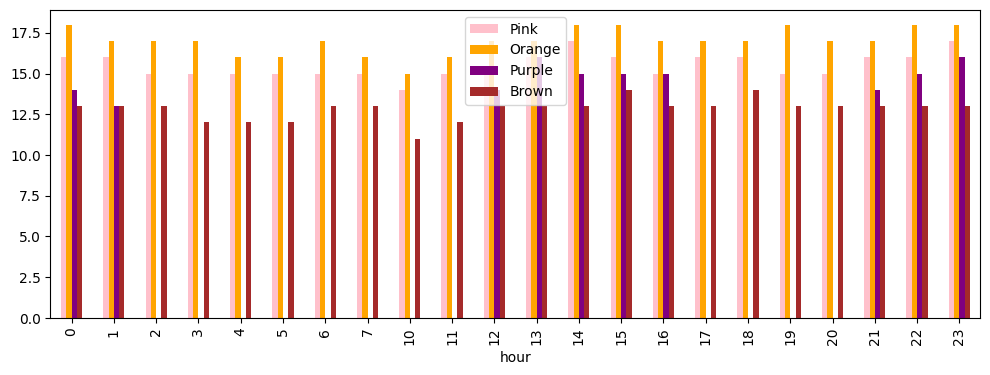

In [427]:
#Grab the brown line
time_diff = get_station_time_diff(35420, 31340)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff['hour'] = time_diff.Datetime.dt.hour
time_diff_des = time_diff.query('Line == "T" and seconds < 1800 and seconds > 540').groupby('hour').TimeDiff.describe()
brown_mean = time_diff_des['mean']


#Grab the purple line
time_diff = get_station_time_diff(35420, 31340)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff['hour'] = time_diff.Datetime.dt.hour
time_diff_des = time_diff.query('Line == "P" and seconds < 1800 and seconds > 540').groupby('hour').TimeDiff.describe()
purple_mean = time_diff_des['mean']


#Grab the Orange line
time_diff = get_station_time_diff(51200, 55340)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff['hour'] = time_diff.Datetime.dt.hour
time_diff_des = time_diff.query('Line == "O" and seconds > 540 and seconds < 1800').groupby('hour').TimeDiff.describe()
orange_mean = time_diff_des['mean']


#Grab the Pink line
time_diff = get_station_time_diff(45340, 41460)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff['hour'] = time_diff.Datetime.dt.hour
time_diff_des = time_diff.query('Line == "V" and seconds > 540 and seconds < 1800').groupby('hour').TimeDiff.describe()
pink_mean = time_diff_des['mean']


#Merge them
merged_mean = pd.merge(pink_mean, orange_mean, on='hour')
merged_mean = merged_mean.rename(columns={'mean_x':'Pink', 'mean_y':'Orange'})
merged_mean = pd.merge(merged_mean, purple_mean, on='hour', how='left')
merged_mean = pd.merge(merged_mean, brown_mean, on='hour', how='left')

merged_mean = merged_mean.rename(columns={'mean_x':'Purple', 'mean_y':'Brown'})

merged_mean = merged_mean.fillna(0)

(merged_mean
    .assign(Purple=merged_mean["Purple"].replace(0,pd.to_timedelta("0 seconds")))
    .astype({c: 'timedelta64[m]' for c in ['Pink', 'Orange', 'Purple', 'Brown']})
    .plot(kind='bar', figsize=(12,4), color=['pink','orange','purple','brown'])
)

AttributeError: 'AxesSubplot' object has no attribute 'hour'

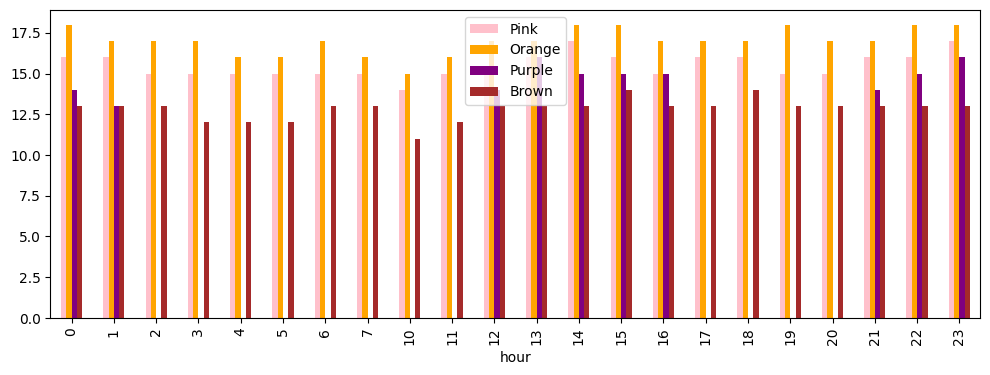

In [428]:
#Grab the brown line
time_diff = get_station_time_diff(35420, 31340)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff['hour'] = time_diff.Datetime.dt.hour
time_diff_des = time_diff.query('Line == "T" and seconds < 1800 and seconds > 540').groupby('hour').TimeDiff.describe()
brown_mean = time_diff_des['mean']


#Grab the purple line
time_diff = get_station_time_diff(35420, 31340)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff['hour'] = time_diff.Datetime.dt.hour
time_diff_des = time_diff.query('Line == "P" and seconds < 1800 and seconds > 540').groupby('hour').TimeDiff.describe()
purple_mean = time_diff_des['mean']


#Grab the Orange line
time_diff = get_station_time_diff(51200, 55340)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff['hour'] = time_diff.Datetime.dt.hour
time_diff_des = time_diff.query('Line == "O" and seconds > 540 and seconds < 1800').groupby('hour').TimeDiff.describe()
orange_mean = time_diff_des['mean']


#Grab the Pink line
time_diff = get_station_time_diff(45340, 41460)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff['hour'] = time_diff.Datetime.dt.hour
time_diff_des = time_diff.query('Line == "V" and seconds > 540 and seconds < 1800').groupby('hour').TimeDiff.describe()
pink_mean = time_diff_des['mean']


#Merge them
merged_mean = pd.merge(pink_mean, orange_mean, on='hour')
merged_mean = merged_mean.rename(columns={'mean_x':'Pink', 'mean_y':'Orange'})
merged_mean = pd.merge(merged_mean, purple_mean, on='hour', how='left')
merged_mean = pd.merge(merged_mean, brown_mean, on='hour', how='left')

merged_mean = merged_mean.rename(columns={'mean_x':'Purple', 'mean_y':'Brown'})

merged_mean = merged_mean.fillna(0)

(merged_mean
    .assign(Purple=merged_mean["Purple"].replace(0,pd.to_timedelta("0 seconds")))
    .astype({c: 'timedelta64[m]' for c in ['Pink', 'Orange', 'Purple', 'Brown']})
    .plot(kind='bar', figsize=(12,4), color=['pink','orange','purple','brown'])
    .hour.set_xticklabels(merged_mean.index, rotation=0)
)

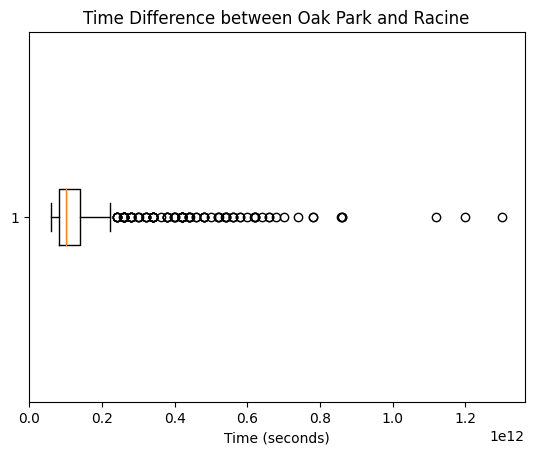

In [429]:
import matplotlib.pyplot as plt
import pandas as pd


time_diff = get_station_time_diff(11631, 11642)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff = time_diff.query('seconds < 1800 and seconds > 45').TimeDiff


fig, ax = plt.subplots()
ax.boxplot(time_diff, vert=False)
ax.set_title('Time Difference between Oak Park and Racine')
ax.set_xlabel('Time (seconds)')
plt.show()



<AxesSubplot: xlabel='Time Difference (seconds)'>

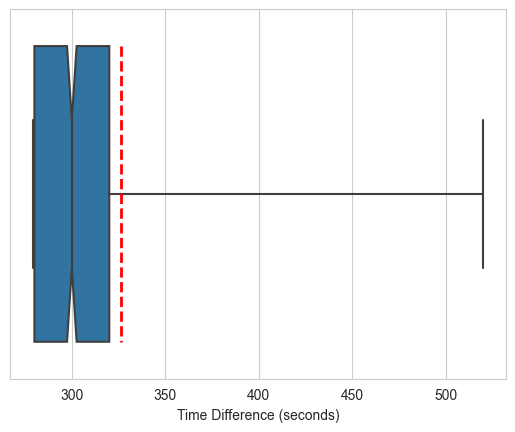

In [434]:
import seaborn as sns
import pandas as pd
import numpy as np

# Replace the code within the parentheses with your own data
time_diff = get_station_time_diff(11604,11631)
time_diff['seconds'] = time_diff.TimeDiff.dt.total_seconds()
time_diff = time_diff.query('seconds < 1800 and seconds > 45').TimeDiff.dt.total_seconds()

# Create a pandas dataframe with your data
df = pd.DataFrame({'Time Difference (seconds)': time_diff})

# Create the horizontal box plot with the standard deviation
sns.boxplot(x="Time Difference (seconds)", data=df, orient="h", showmeans=True, meanline=True, meanprops={"linewidth": 2, "color": "red"}, showfliers=False, whis=[5, 95], notch=True)


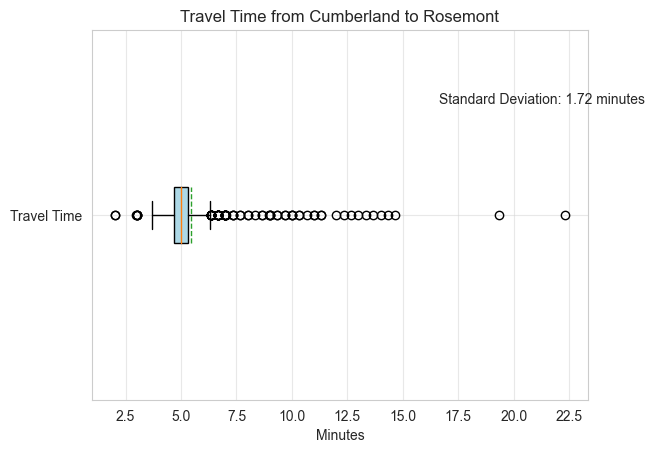

In [436]:
import matplotlib.pyplot as plt
import pandas as pd

# Get time differences and convert to seconds
time_diff = get_station_time_diff(11604,11631)
time_diff['minutes'] = time_diff.TimeDiff.dt.total_seconds() / 60

# Filter data
time_diff = time_diff.query('minutes < 30 and minutes > 1')

# Create horizontal box plot
fig, ax = plt.subplots()
ax.boxplot(time_diff['minutes'], vert=False, showmeans=True, meanline=True, 
           labels=['Travel Time'], patch_artist=True, boxprops=dict(facecolor='lightblue'))
ax.set_title('Travel Time from Cumberland to Rosemont')
ax.set_xlabel('Minutes')
ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)

# Add standard deviation as text
std_minutes = time_diff['minutes'].std()
ax.text(0.7, 0.8, f'Standard Deviation: {std_minutes:.2f} minutes', transform=ax.transAxes)

plt.show()
